# Imports / Config

In [1]:
from functools import reduce
import itertools
import os
import sys

from datetime import datetime, timedelta
from dateutil.parser import parse as timeparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
from pymongo import MongoClient
from scipy.sparse import hstack
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import density
import spacy
from tqdm import tqdm_notebook

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import configs
%matplotlib inline
nlp = spacy.load('en_core_web_lg')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
#MongoDB Config
mdb_client = MongoClient(configs.MDB_HOST)
milli_mdb = mdb_client.milli_mdb
parsed_content = milli_mdb.parsed_content

In [3]:
#topics & associated feed keywords
TOPIC_CLASSIFICATIONS_AND_KEYWORDS = {
    'Politics, Policy & Economics':['economics', 'policy', 'politics'],
    'Finance & Business':['companies', 'business', 'finance', 'money', 
                          'real estate', 'stocks'],
    'Technology, Science & Medicine':['science', 'tech', 'medicine'],
    'Sports':['baseball', 'basketball', 'cbb', 'cfb', 'football', 'golf', 
              'hockey', 'mlb', 'nba', 'nfl', 'nhl', 'soccer', 'sport', 
              'tennis'],
    'Entertainment, Culture & Arts':['art', 'book', 'celebrit', 'culture', 
                                     'entertainment', 'music'],
    'Travel, Lifestyle & Food':['food', 'life', 'living', 'relationship', 
                                'sex', 'style', 'travel', 'wellness']
}

#inclusion logic: union of top-30 countries by population and top-30 countries by GDP
REGION_CLASSIFICATIONS_AND_KEYWORDS = {
    'U.S. & Canada':['canada', 'united states', 'u.s.'],
    'Latin America':['americas', 'argentina', 'brazil', 'colombia',
                     'latam', 'latin america', 'mexico'],
    'Europe':['austria', 'belgium', 'europe', 'france', 'germany', 'italy',
              'netherlands', 'norway', 'poland', 'russia', 'spain', 'sweden',
              'switzerland', 'united kingdom', 'u.k.'],
    'Middle East & Africa':['africa', 'congo', 'ethiopia', 'egypt', 'emirates', 
                            'iran', 'kenya', 'middle east', 'nigeria', 'saudi', 
                            'tanzania', 'turkey', 'u.a.e.'],
    'Asia':['asia', 'austral', 'bangladesh', 'china', 'india', 'indonesia', 
            'japan', 'korea', 'myanmar', 'pakistan', 'philippines', 'taiwan',
            'thailand', 'vietnam']
}

# Gather UCI Training Content
Source: https://www.kaggle.com/uciml/news-aggregator-dataset

In [4]:
uci_news_data = pd.read_csv('/Users/robdearborn/Downloads/uci-news-aggregator.csv')
uci_news_data.drop(columns=['ID', 'PUBLISHER', 'HOSTNAME', 'TIMESTAMP'], inplace=True)
uci_news_data = uci_news_data.rename(index=str, columns={'TITLE':'title',
                                                         'URL':'url', 
                                                         'CATEGORY':'uci_category',
                                                         'STORY':'uci_story_id'}
)
uci_news_data.head()

title  \
0  Fed official says weak data caused by weather,...   
1  Fed's Charles Plosser sees high bar for change...   
2  US open: Stocks fall after Fed official hints ...   
3  Fed risks falling 'behind the curve', Charles ...   
4  Fed's Plosser: Nasty Weather Has Curbed Job Gr...   

                                                 url uci_category  \
0  http://www.latimes.com/business/money/la-fi-mo...            b   
1  http://www.livemint.com/Politics/H2EvwJSK2VE6O...            b   
2  http://www.ifamagazine.com/news/us-open-stocks...            b   
3  http://www.ifamagazine.com/news/fed-risks-fall...            b   
4  http://www.moneynews.com/Economy/federal-reser...            b   

                    uci_story_id  
0  ddUyU0VZz0BRneMioxUPQVP6sIxvM  
1  ddUyU0VZz0BRneMioxUPQVP6sIxvM  
2  ddUyU0VZz0BRneMioxUPQVP6sIxvM  
3  ddUyU0VZz0BRneMioxUPQVP6sIxvM  
4  ddUyU0VZz0BRneMioxUPQVP6sIxvM

# Query for Feeds to be Used for Classification Training

In [5]:
def get_publisher_feeds():
    sql = """
        SELECT publisher, subcategory, url AS feed_url
        FROM feeds
    """    
    pg_conn = psycopg2.connect(host=configs.PG_HOST,
                           dbname=configs.PG_DBNAME,
                           user=configs.PG_USER,
                           password=configs.PG_PASSWORD)
    pg_cursor = pg_conn.cursor()
    pg_cursor.execute(sql)
    feeds_data = pg_cursor.fetchall()
    pg_cursor.close()
    pg_conn.close()
    
    feeds_df = pd.DataFrame(feeds_data, columns=['publisher', 
                                                 'subcategory', 
                                                 'feed_url'])
    feeds_df['region_classification'] = feeds_df['subcategory'].apply(
        lambda x: classify_feed_subcategory(x.lower(), 
                                            REGION_CLASSIFICATIONS_AND_KEYWORDS)
    )    
    feeds_df['topic_classification'] = feeds_df['subcategory'].apply(
        lambda x: classify_feed_subcategory(x.lower(), 
                                            TOPIC_CLASSIFICATIONS_AND_KEYWORDS)
    )
    
    return feeds_df


def classify_feed_subcategory(feed_subcategory, classifications_and_keywords):
    for classification, keywords in classifications_and_keywords.items():
        for keyword in keywords:
            if keyword in feed_subcategory:
                return classification        
    return None

In [6]:
feeds_df = get_publisher_feeds()

In [7]:
feeds_df.head()

publisher                  subcategory  \
0                 Nasdaq  Investing - Investing Ideas   
1     The Times of India                     Business   
2                   Time                  Top Stories   
3               Sky News                         U.K.   
4  MIT Technology Review                  Top Stories   

                                            feed_url region_classification  \
0  http://articlefeeds.nasdaq.com/nasdaq/categori...                  None   
1  http://timesofindia.indiatimes.com/rssfeeds/18...                  None   
2       http://feeds2.feedburner.com/time/topstories                  None   
3          http://feeds.skynews.com/feeds/rss/uk.xml                Europe   
4       https://www.technologyreview.com/topnews.rss                  None   

  topic_classification  
0                 None  
1   Finance & Business  
2                 None  
3                 None  
4                 None

In [8]:
feeds_df['topic_classification'].value_counts()

Finance & Business                47
Technology, Science & Medicine    34
Sports                            34
Entertainment, Culture & Arts     33
Travel, Lifestyle & Food          31
Politics, Policy & Economics      24
Name: topic_classification, dtype: int64

In [9]:
feeds_df['region_classification'].value_counts()

Asia                    23
U.S. & Canada           18
Europe                  11
Middle East & Africa     9
Latin America            7
Name: region_classification, dtype: int64

# Gather Recently Crawled Content

In [10]:
start_timestamp = str(datetime.utcnow() - timedelta(days = 7))

recent_docs_cursor = parsed_content.find(
    {'crawled_timestamp':{'$gt':start_timestamp},
     'title_language':'en'}
)

In [11]:
%%time
to_concat = []
for doc in recent_docs_cursor:
    record = pd.DataFrame({
        'url':[doc['url']],
        'crawled_timestamp':[timeparse(doc['crawled_timestamp'])],
        'title':[doc['title']],
        'feed_url':[doc['feed_url']],
        'meta_keywords':[' '.join(doc['meta_keywords'])],
        'text':[doc['text']],
        'title_language':[doc['title_language']],
    })
    to_concat += [record]    
recent_docs = pd.concat(to_concat).reset_index()
recent_docs['text_word_count'] = recent_docs['text'].apply(lambda x: len(x.split()))
recent_docs.drop(labels=['index'], axis='columns', inplace=True)

CPU times: user 2min, sys: 4.31 s, total: 2min 4s
Wall time: 3min 8s


In [12]:
recent_docs = recent_docs.merge(
    feeds_df[['feed_url', 'region_classification', 'topic_classification']],
    how='left'
)

In [13]:
print('Number of Docs: '+ str(len(recent_docs)))
print('Size of Docs (MB): '+ str(sys.getsizeof(recent_docs)/1000000.0))

Number of Docs: 93455
Size of Docs (MB): 579.622741


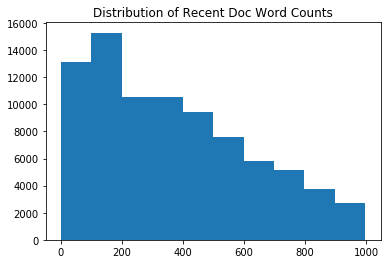

In [14]:
dist = recent_docs['text_word_count']
rng = (0, np.percentile(dist, 90))
plt.hist(dist, range=rng)
plt.title('Distribution of Recent Doc Word Counts')
plt.show()

In [15]:
recent_docs.head()

crawled_timestamp  \
0 2018-08-22 22:32:20.941572   
1 2018-08-22 22:32:25.842118   
2 2018-08-22 22:32:30.966894   
3 2018-08-22 22:32:33.902670   
4 2018-08-22 22:32:40.031606   

                                            feed_url meta_keywords  \
0          https://www.aljazeera.com/xml/rss/all.xml                 
1                             https://www.afp.com/en                 
2  http://feeds.bbci.co.uk/news/world/middle_east...                 
3              http://feeds.bbci.co.uk/sport/rss.xml                 
4                          https://www.breitbart.com                 

                                                text  \
0  People in India's flood-ravaged state of Keral...   
1  AFP/File / ANGELA WEISS Focusing on a highly i...   
2  Image copyright AFP Image caption Abu Bakr al-...   
3  Kyle Lafferty was back in Rangers training gea...   
4  Jimmy Bennett broke his silence and commented ...   

                                               title title_language  \
0  Kerala flood survivors face 'great struggle' t...             en   
1    Next season of 'Big Bang Theory' to be its last             en   
2  Islamic State: 'New audio' of leader Al-Baghda...             en   
3  Kyle Lafferty a 'no risk' signing, says Ranger...             en   
4  Jimmy Bennett Breaks His Silence on Asia Argen...             en   

                                                 url  text_word_count  \
0  https://www.aljazeera.com/news/2018/08/kerala-...              663   
1  https://www.afp.com/en/news/206/next-season-bi...              373   
2  https://www.bbc.co.uk/news/world-middle-east-4...              222   
3       http://www.bbc.co.uk/sport/football/45274228              332   
4  https://www.breitbart.com/big-hollywood/2018/0...              387   

  region_classification topic_classification  
0                  None                 None  
1                  None                 None  
2  Middle East & Africa                 None  
3                  None               Sports  
4                  None                 None

# Create TF-IDF Matrices

In [16]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), stop_words='english', min_df=2, max_df=0.5
)

In [17]:
%%time 
titles_tfidf_matrix = tfidf_vectorizer.fit_transform(
    list(recent_docs['title'])
)
titles_tfidf_vocab = tfidf_vectorizer.get_feature_names()
print('Title vocab size: '+ str(len(titles_tfidf_vocab)))

Title vocab size: 131714
CPU times: user 3.39 s, sys: 64.9 ms, total: 3.45 s
Wall time: 3.45 s


In [18]:
%%time 
texts_tfidf_matrix = tfidf_vectorizer.fit_transform(
    list(recent_docs['text'])
)
texts_tfidf_vocab = tfidf_vectorizer.get_feature_names()
print('Text vocab size: '+ str(len(texts_tfidf_vocab)))

Text vocab size: 3463823
CPU times: user 2min 37s, sys: 6.49 s, total: 2min 44s
Wall time: 2min 47s


In [19]:
%%time 
meta_tfidf_matrix = tfidf_vectorizer.fit_transform(
    list(recent_docs['meta_keywords'])
)
meta_tfidf_vocab = tfidf_vectorizer.get_feature_names()
print('Meta vocab size: '+ str(len(meta_tfidf_vocab)))

Meta vocab size: 80499
CPU times: user 3.83 s, sys: 332 ms, total: 4.16 s
Wall time: 4.37 s


In [20]:
master_tfidf_matrix = hstack(
    [titles_tfidf_matrix, texts_tfidf_matrix, meta_tfidf_matrix]
).tocsr()
master_tfidf_vocab = titles_tfidf_vocab + texts_tfidf_vocab + meta_tfidf_vocab

# Topic Classification

## Final Methodology

### Training

In [21]:
doc_filter = (~recent_docs['topic_classification'].isna())

classified_docs = recent_docs[doc_filter].copy().reset_index()
classified_docs.drop(labels=['index'], axis='columns', inplace=True)

indexes = np.where(doc_filter)
classified_master_tfidf_matrix = master_tfidf_matrix[indexes]

In [22]:
X = classified_master_tfidf_matrix
y = classified_docs['topic_classification'].copy()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
sgd = SGDClassifier(
    max_iter=10,
    n_jobs=2,
    loss='modified_huber',
    learning_rate='optimal',
    penalty='elasticnet',
    alpha=0.0001,
    l1_ratio=0.5,
)

In [25]:
%%time 
sgd.fit(X_train, y_train)

CPU times: user 7.62 s, sys: 139 ms, total: 7.76 s
Wall time: 4.05 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.5, learning_rate='optimal',
       loss='modified_huber', max_iter=10, n_iter=None, n_jobs=2,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [26]:
pred = sgd.predict(X_test)

In [27]:
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.891


In [28]:
class_names = sorted(y.unique())

In [29]:
print('*****Classification Training Report*****')
print("dimensionality: %d" % sgd.coef_.shape[1])
print("density: %f" % density(sgd.coef_))
print()
print("top 10 keywords per class:")
for i, label in enumerate(class_names):
    vocab = ''
    for j in np.argsort(sgd.coef_[i])[-10:]:
        vocab = vocab + ' ' + master_tfidf_vocab[j]
    print("%s: %s" % (label, vocab))
print()
print("classification report:")
print(metrics.classification_report(y_test, pred))
print()
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, pred))

*****Classification Training Report*****
dimensionality: 3676036
density: 0.000858

top 10 keywords per class:
Entertainment, Culture & Arts:  aug star character culture smg2_entertainment actor actress film entertainment singer
Finance & Business:  investment market business smg_business bank business sales workers company fin24
Politics, Policy & Economics:  democrats trump political news president trump primary cuomo advertisement politics mccain cnnpolitics
Sports:  race team sports today sports cup football game club league coach
Technology, Science & Medicine:  science technology news earth printed technology business car scientists nasa buzz60 technology
Travel, Lifestyle & Food:  travel smg_life bride montclair recipes style nj smg2_life travel lifestyle

classification report:
                                precision    recall  f1-score   support

 Entertainment, Culture & Arts       0.80      0.90      0.85       392
            Finance & Business       0.81      0.85      0

### Assignment

In [30]:
recent_docs['topic_classification_predicted'] = (
    sgd.predict(master_tfidf_matrix)
)
recent_docs['topic_classification_probability'] = (
    np.exp(sgd.predict_log_proba(master_tfidf_matrix)).max(axis=1)
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


*****Politics, Policy & Economics*****


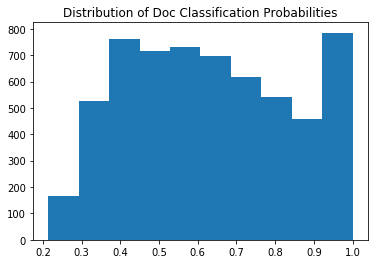


*****Finance & Business*****


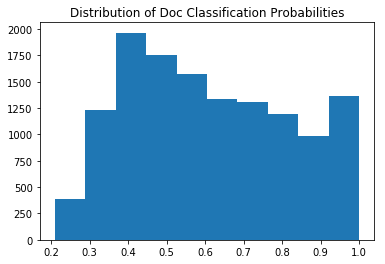


*****Technology, Science & Medicine*****


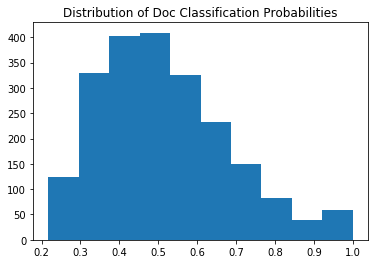


*****Sports*****


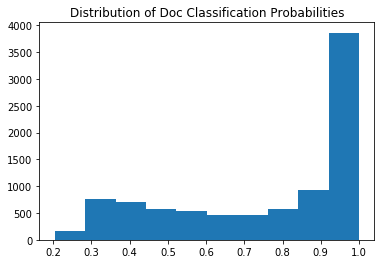


*****Entertainment, Culture & Arts*****


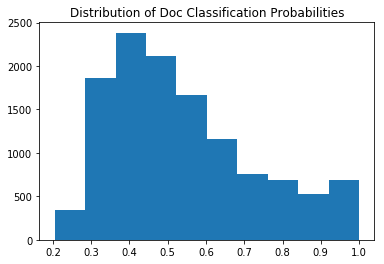


*****Travel, Lifestyle & Food*****


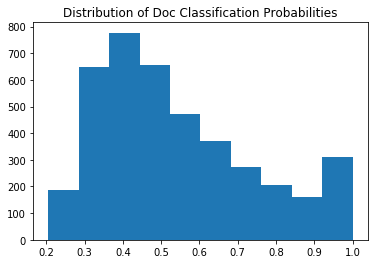

In [31]:
for classification, keywords in TOPIC_CLASSIFICATIONS_AND_KEYWORDS.items():
    doc_filter = ((recent_docs['topic_classification_predicted'] == classification)
                  & (recent_docs['crawled_timestamp'] >= datetime.utcnow() - timedelta(days = 2)))
    class_docs = recent_docs.loc[doc_filter]
    print('*****'+classification+'*****')
    plt.hist(class_docs['topic_classification_probability'])
    plt.title('Distribution of Doc Classification Probabilities')
    plt.show()
    print()

In [32]:
print('')
for classification, keywords in TOPIC_CLASSIFICATIONS_AND_KEYWORDS.items():
    doc_filter = ((recent_docs['topic_classification_predicted'] == classification)
                  & (recent_docs['crawled_timestamp'] >= datetime.utcnow() - timedelta(days = 2))
                  & (recent_docs['topic_classification_probability'] > 0.5))
    class_docs = recent_docs.loc[doc_filter]
    print('*****'+classification+'*****')
    print('Sample of Article Titles in Class')
    print(class_docs['title'].sample(20))
    print()


*****Politics, Policy & Economics*****
Sample of Article Titles in Class
55727    John McCain's death roils rough-and-tumble Rep...
57651    Is Trump going to be impeached? What Bill Clin...
59488    Merkel condemns Chemnitz stabbing and violent ...
90695    The Latest: Trump says he hasn't heard DeSanti...
88709    Arizonans pay final farewell to late Senator J...
88270    Trump-backed candidate's 'monkey' comment draw...
66802    Senate confirms Columbia University professor ...
47587    ‘A nation of ideals, not blood and soil’: read...
82304    Google Trump: Web searches on the president ar...
67679    Puerto Rico death toll official estimate from ...
87928    History-making nights in Florida, Arizona prim...
90273    Family mourn the late Sen. John McCain at Ariz...
66309    Lindsey Graham gives a tearful tribute to John...
52957    Jeff Greene tries to sell Florida Democrats on...
62538    Cynthia Nixon battles with Cuomo over temperat...
50512    We are not seeing a fair present

## Classification Methodology Accuracy Experimentation
- **SGDC: 0.894 & 0.76 s**
- Passive Aggressive: 0.893 & 0.89 s
- Perceptron: 0.874 & 0.79 s
- LSVC: 0.893 & 7.32s
- Logistic Regression: 0.845 & 9.75 s
- Nearest Centroid: 0.678 & 0.33 s
- KNN classifier: 0.323 & 0.02 s
- RF: 0.755 & 114 s
- MLP (1000,) / tanh / constant: dead :(
- MLP (100,) / tanh / constant: 0.866 & 1526 s
- MLP (30,) / tanh / constant: 0.859 & 847 s
- MLP (10,) / tanh / constant: 0.860 & 315 s
- MLP (6,) / tanh / constant: 0.851 & 237
- MLP (3,) / tanh / constant: 0.628 & 20.4 s

(MLP after restart)
- MLP (10,) / identity / adaptive: 0.857 & 293 s
- MLP (10,) / logistic / adaptive: 0.849 & 638 s
- MLP (10,) / relu / adaptive: 0.849 & 273 s
- MLP (10,) / tanh / adaptive: 0.858 & 239 s

In [ ]:
for i in [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]:
    for j in np.arange(0, 1, 0.1):
        scores = []
        for k in np.arange(0, 10):
            clf = SGDClassifier(
                max_iter=10,
                n_jobs=2,
                loss='modified_huber',
                learning_rate='optimal',
                penalty='elasticnet',
                alpha=i,
                l1_ratio=j,
            )
            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            score = metrics.accuracy_score(y_test, pred)
            scores += [score]
        avg_score = np.mean(scores)
        print('alpha: %f | l1_ratio: %f | score: %0.4f' % (i, j, avg_score))

In [ ]:
for i in [1, 10, 100]:
    scores = []
    for k in np.arange(0, 10):
        clf = SGDClassifier(
            max_iter=i,
            n_jobs=2,
            loss='modified_huber',
            learning_rate='optimal',
            penalty='elasticnet',
            alpha=0.0001,
            l1_ratio=0.5,
        )
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        score = metrics.accuracy_score(y_test, pred)
        scores += [score]
    avg_score = np.mean(scores)
    print('max_iter: %d | score: %0.4f' % (i, avg_score))

## SGDC Hyperparameter Accuracy Experimentation
(all: max_iter=10, n_jobs=2, loss='hinge', learning_rate='optimal', penalty='elasticnet')
- alpha: 0.000001 | l1_ratio: 0.00 | score: 0.8805
- alpha: 0.000001 | l1_ratio: 0.10 | score: 0.8814
- alpha: 0.000001 | l1_ratio: 0.20 | score: 0.8844
- alpha: 0.000001 | l1_ratio: 0.30 | score: 0.8820
- alpha: 0.000001 | l1_ratio: 0.40 | score: 0.8828
- alpha: 0.000001 | l1_ratio: 0.50 | score: 0.8838
- alpha: 0.000001 | l1_ratio: 0.60 | score: 0.8848
- alpha: 0.000001 | l1_ratio: 0.70 | score: 0.8836
- alpha: 0.000001 | l1_ratio: 0.80 | score: 0.8855
- alpha: 0.000001 | l1_ratio: 0.90 | score: 0.8850
- alpha: 0.000010 | l1_ratio: 0.00 | score: 0.8825
- alpha: 0.000010 | l1_ratio: 0.10 | score: 0.8852
- alpha: 0.000010 | l1_ratio: 0.20 | score: 0.8876
- alpha: 0.000010 | l1_ratio: 0.30 | score: 0.8865
- alpha: 0.000010 | l1_ratio: 0.40 | score: 0.8872
- alpha: 0.000010 | l1_ratio: 0.50 | score: 0.8869
- alpha: 0.000010 | l1_ratio: 0.60 | score: 0.8840
- alpha: 0.000010 | l1_ratio: 0.70 | score: 0.8842
- alpha: 0.000010 | l1_ratio: 0.80 | score: 0.8814
- alpha: 0.000010 | l1_ratio: 0.90 | score: 0.8840
- alpha: 0.000100 | l1_ratio: 0.00 | score: 0.8855
- alpha: 0.000100 | l1_ratio: 0.10 | score: 0.8879
- **alpha: 0.000100 | l1_ratio: 0.20 | score: 0.8881**
- alpha: 0.000100 | l1_ratio: 0.30 | score: 0.8865
- alpha: 0.000100 | l1_ratio: 0.40 | score: 0.8862
- alpha: 0.000100 | l1_ratio: 0.50 | score: 0.8870
- alpha: 0.000100 | l1_ratio: 0.60 | score: 0.8853
- alpha: 0.000100 | l1_ratio: 0.70 | score: 0.8847
- alpha: 0.000100 | l1_ratio: 0.80 | score: 0.8830
- alpha: 0.000100 | l1_ratio: 0.90 | score: 0.8823
- alpha: 0.001000 | l1_ratio: 0.00 | score: 0.8608
- alpha: 0.001000 | l1_ratio: 0.10 | score: 0.8055
- alpha: 0.001000 | l1_ratio: 0.20 | score: 0.7752
- alpha: 0.001000 | l1_ratio: 0.30 | score: 0.7671
- alpha: 0.001000 | l1_ratio: 0.40 | score: 0.7542
- alpha: 0.001000 | l1_ratio: 0.50 | score: 0.7388
- alpha: 0.001000 | l1_ratio: 0.60 | score: 0.7292
- alpha: 0.001000 | l1_ratio: 0.70 | score: 0.7263
- alpha: 0.001000 | l1_ratio: 0.80 | score: 0.7219
- alpha: 0.001000 | l1_ratio: 0.90 | score: 0.7208
- alpha: 0.010000 | l1_ratio: 0.00 | score: 0.5911
- alpha: 0.010000 | l1_ratio: 0.10 | score: 0.5358
- alpha: 0.010000 | l1_ratio: 0.20 | score: 0.5320
- alpha: 0.010000 | l1_ratio: 0.30 | score: 0.5317
- alpha: 0.010000 | l1_ratio: 0.40 | score: 0.5317
- alpha: 0.010000 | l1_ratio: 0.50 | score: 0.5317
- alpha: 0.010000 | l1_ratio: 0.60 | score: 0.5318
- alpha: 0.010000 | l1_ratio: 0.70 | score: 0.5319
- alpha: 0.010000 | l1_ratio: 0.80 | score: 0.5317
- alpha: 0.010000 | l1_ratio: 0.90 | score: 0.5320
- alpha: 0.100000 | l1_ratio: 0.00 | score: 0.5316
- alpha: 0.100000 | l1_ratio: 0.10 | score: 0.5316
- alpha: 0.100000 | l1_ratio: 0.20 | score: 0.5316
- alpha: 0.100000 | l1_ratio: 0.30 | score: 0.5316
- alpha: 0.100000 | l1_ratio: 0.40 | score: 0.5316
- alpha: 0.100000 | l1_ratio: 0.50 | score: 0.5316
- alpha: 0.100000 | l1_ratio: 0.60 | score: 0.5316
- alpha: 0.100000 | l1_ratio: 0.70 | score: 0.5316
- alpha: 0.100000 | l1_ratio: 0.80 | score: 0.5316
- alpha: 0.100000 | l1_ratio: 0.90 | score: 0.5316

(all: alpha=0.0001, l1_ratio=0.15, n_jobs=2, loss='hinge', learning_rate='optimal', penalty='elasticnet')
- **max_iter: 1 | score: 0.8883**
- max_iter: 10 | score: 0.8872
- max_iter: 100 | score: 0.8875
- max_iter: 1000 | score: 0.8877

(all: max_iter=10, n_jobs=2, loss='modified_huber', learning_rate='optimal', penalty='elasticnet')
- alpha: 0.000001 | l1_ratio: 0.000000 | score: 0.8621
- alpha: 0.000001 | l1_ratio: 0.100000 | score: 0.8654
- alpha: 0.000001 | l1_ratio: 0.200000 | score: 0.8660
- alpha: 0.000001 | l1_ratio: 0.300000 | score: 0.8645
- alpha: 0.000001 | l1_ratio: 0.400000 | score: 0.8662
- alpha: 0.000001 | l1_ratio: 0.500000 | score: 0.8641
- alpha: 0.000001 | l1_ratio: 0.600000 | score: 0.8649
- alpha: 0.000001 | l1_ratio: 0.700000 | score: 0.8668
- alpha: 0.000001 | l1_ratio: 0.800000 | score: 0.8667
- alpha: 0.000001 | l1_ratio: 0.900000 | score: 0.8680
- alpha: 0.000010 | l1_ratio: 0.000000 | score: 0.8611
- alpha: 0.000010 | l1_ratio: 0.100000 | score: 0.8637
- alpha: 0.000010 | l1_ratio: 0.200000 | score: 0.8655
- alpha: 0.000010 | l1_ratio: 0.300000 | score: 0.8650
- alpha: 0.000010 | l1_ratio: 0.400000 | score: 0.8645
- alpha: 0.000010 | l1_ratio: 0.500000 | score: 0.8648
- alpha: 0.000010 | l1_ratio: 0.600000 | score: 0.8658
- alpha: 0.000010 | l1_ratio: 0.700000 | score: 0.8642
- alpha: 0.000010 | l1_ratio: 0.800000 | score: 0.8634
- alpha: 0.000010 | l1_ratio: 0.900000 | score: 0.8630
- alpha: 0.000100 | l1_ratio: 0.000000 | score: 0.8730
- alpha: 0.000100 | l1_ratio: 0.100000 | score: 0.8749
- alpha: 0.000100 | l1_ratio: 0.200000 | score: 0.8773
- alpha: 0.000100 | l1_ratio: 0.300000 | score: 0.8787
- alpha: 0.000100 | l1_ratio: 0.400000 | score: 0.8780
- **alpha: 0.000100 | l1_ratio: 0.500000 | score: 0.8790**
- alpha: 0.000100 | l1_ratio: 0.600000 | score: 0.8777
- alpha: 0.000100 | l1_ratio: 0.700000 | score: 0.8765
- alpha: 0.000100 | l1_ratio: 0.800000 | score: 0.8760
- alpha: 0.000100 | l1_ratio: 0.900000 | score: 0.8717
- alpha: 0.001000 | l1_ratio: 0.000000 | score: 0.8608
- alpha: 0.001000 | l1_ratio: 0.100000 | score: 0.8467
- alpha: 0.001000 | l1_ratio: 0.200000 | score: 0.8365
- alpha: 0.001000 | l1_ratio: 0.300000 | score: 0.8263
- alpha: 0.001000 | l1_ratio: 0.400000 | score: 0.8192
- alpha: 0.001000 | l1_ratio: 0.500000 | score: 0.8124
- alpha: 0.001000 | l1_ratio: 0.600000 | score: 0.8047
- alpha: 0.001000 | l1_ratio: 0.700000 | score: 0.7979
- alpha: 0.001000 | l1_ratio: 0.800000 | score: 0.7916
- alpha: 0.001000 | l1_ratio: 0.900000 | score: 0.7860
- alpha: 0.010000 | l1_ratio: 0.000000 | score: 0.6512
- alpha: 0.010000 | l1_ratio: 0.100000 | score: 0.5007
- alpha: 0.010000 | l1_ratio: 0.200000 | score: 0.4718
- alpha: 0.010000 | l1_ratio: 0.300000 | score: 0.4524
- alpha: 0.010000 | l1_ratio: 0.400000 | score: 0.4372
- alpha: 0.010000 | l1_ratio: 0.500000 | score: 0.4255
- alpha: 0.010000 | l1_ratio: 0.600000 | score: 0.4186
- alpha: 0.010000 | l1_ratio: 0.700000 | score: 0.4167
- alpha: 0.010000 | l1_ratio: 0.800000 | score: 0.4139
- alpha: 0.010000 | l1_ratio: 0.900000 | score: 0.4144
- alpha: 0.100000 | l1_ratio: 0.000000 | score: 0.4048
- alpha: 0.100000 | l1_ratio: 0.100000 | score: 0.4043
- alpha: 0.100000 | l1_ratio: 0.200000 | score: 0.4043
- alpha: 0.100000 | l1_ratio: 0.300000 | score: 0.4043
- alpha: 0.100000 | l1_ratio: 0.400000 | score: 0.4043
- alpha: 0.100000 | l1_ratio: 0.500000 | score: 0.4043
- alpha: 0.100000 | l1_ratio: 0.600000 | score: 0.4043
- alpha: 0.100000 | l1_ratio: 0.700000 | score: 0.4043
- alpha: 0.100000 | l1_ratio: 0.800000 | score: 0.4043
- alpha: 0.100000 | l1_ratio: 0.900000 | score: 0.4043

(all: alpha=0.0001, l1_ratio=0.50, n_jobs=2, loss='modified_huber', learning_rate='optimal', penalty='elasticnet')
- max_iter: 1 | score: 0.8688
- max_iter: 10 | score: 0.8794
- max_iter: 100 | score: 0.8789


# Topic Clustering

In [33]:
def lemmatize(text, pos_to_keep=['NOUN', 'PROPN'], override_pos_filter=False, str_output=True):
    doc = nlp(text, disable=['parser', 'ner'])
    lemmas = [
        token.lemma_ for token in doc 
        if (not token.is_stop 
            and (token.pos_ in pos_to_keep
                 or override_pos_filter))
    ]
    if str_output:
        lemmas = ' '.join(lemmas)
    
    return lemmas

In [34]:
doc_filter = (
    (recent_docs['topic_classification_predicted'] == 'Politics, Policy & Economics')
#     & (recent_docs['crawled_timestamp'] >= datetime.utcnow() - timedelta(days = 2))
    & (recent_docs['topic_classification_probability'] > 0.25)
#     & (recent_docs['text_word_count'] > 200)
)

class_docs = recent_docs[doc_filter].copy().reset_index()
class_docs.drop(labels=['index'], axis='columns', inplace=True)

In [35]:
class_docs['title_processed'] = (
    class_docs['title'].apply(lemmatize)
)

In [36]:
n_class_docs = len(class_docs)
print('Number of Docs: '+ str(n_class_docs))

Number of Docs: 13949


In [37]:
%%time

uci_news_data_sample = pd.DataFrame()
story_ids_and_n_docs = {}
while len(uci_news_data_sample) <= n_class_docs:
    rndidx = np.random.randint(0, len(uci_news_data))
    story_id = uci_news_data['uci_story_id'][rndidx]
    filt = (uci_news_data['uci_story_id'] == story_id)
    story_ids_and_n_docs[story_id] = sum(filt)
    uci_news_data_sample = (
        pd.concat([uci_news_data_sample, uci_news_data[filt]], ignore_index=True)
    )

CPU times: user 5.33 s, sys: 173 ms, total: 5.5 s
Wall time: 5.67 s


In [38]:
uci_news_data_sample['title_processed'] = (
    uci_news_data_sample['title'].apply(lemmatize)
)

In [39]:
n_uci_docs = len(uci_news_data_sample)
print('Number of Docs: '+ str(n_uci_docs))

Number of Docs: 13982


In [40]:
class_docs_plus = pd.concat([class_docs, uci_news_data_sample], ignore_index=True)
class_docs_plus.head()

crawled_timestamp                         feed_url meta_keywords  \
0 2018-08-22 22:32:43.432918        https://www.breitbart.com                 
1 2018-08-22 22:32:44.772823  https://www.businessinsider.com                 
2 2018-08-22 22:32:47.277760  https://www.businessinsider.com                 
3 2018-08-22 22:32:51.256057        https://www.breitbart.com                 
4 2018-08-22 22:32:51.731803        https://www.breitbart.com                 

  region_classification                                               text  \
0                  None  Lanny Davis, the attorney for President Donald...   
1                  None  Win McNamee/Getty Images Alex Stamos.\n\nFaceb...   
2                  None  Republican Rep. Duncan Hunter of California bl...   
3                  None  New York (AFP) – Michael Cohen’s transformatio...   
4                  None  WASHINGTON (AP) — President Donald Trump accus...   

   text_word_count                                              title  \
0            528.0  Lanny Davis: No New Evidence, Just ‘Mr. Cohen’...   
1            643.0  Facebook's former security chief warns that 'i...   
2            528.0  'It's happening with Trump, it's happening wit...   
3            708.0  Et tu, Cohen? Ex-aide could be tip of Trump ic...   
4            894.0  With White House stung by Cohen accusation, Tr...   

  title_language                                    title_processed  \
0             en  lanny davis new evidence mr. cohen word mr. tr...   
1             en                   facebook security chief election   
2             en  trump congressman duncan hunter justice depart...   
3             en              et tu cohen ex aide tip trump iceberg   
4             en                 white house cohen accusation trump   

  topic_classification topic_classification_predicted  \
0                 None   Politics, Policy & Economics   
1                 None   Politics, Policy & Economics   
2                 None   Politics, Policy & Economics   
3                 None   Politics, Policy & Economics   
4                 None   Politics, Policy & Economics   

   topic_classification_probability uci_category uci_story_id  \
0                          0.546136          NaN          NaN   
1                          0.362027          NaN          NaN   
2                          0.710818          NaN          NaN   
3                          0.665564          NaN          NaN   
4                          0.728780          NaN          NaN   

                                                 url  
0  https://www.breitbart.com/big-government/2018/...  
1  https://www.businessinsider.com.au/alex-stamos...  
2  https://www.businessinsider.com.au/duncan-hunt...  
3  https://www.breitbart.com/news/et-tu-cohen-ex-...  
4  https://www.breitbart.com/news/with-white-hous...

In [41]:
n_class_docs_plus = len(class_docs_plus)
print('Number of Docs Plus: '+ str(n_class_docs_plus))

Number of Docs Plus: 27931


In [42]:
query = 'cohen'

def gen_ac_nodes(ac_model):
    ii = itertools.count(ac_model.n_leaves_)
    ac_nodes = [
        {'idx': next(ii), 
         'left_child': int(x[0]), 
         'right_child': int(x[1])} 
        for x in ac_model.children_
    ]
    
    return ac_nodes


def plot_ac_tradeoff(ac_model, docs, story_ids_and_n_docs, nodes_to_process_between_plots=100):
    docs_ = docs.copy()
    n_docs = ac_model.n_leaves_
    
    ac_nodes = gen_ac_nodes(ac_model)
    
    cluster_doc_ids = {}
    for i in np.arange(0, n_docs):
        cluster_doc_ids[i] = [i]
    doc_clusters = np.arange(0, n_docs)
    
    n_clusters = []
    avg_story_tc_recalls = []
    avg_story_tc_precisions = []
    avg_story_tc_f1_scores = []
    
    for node in tqdm_notebook(ac_nodes):
        idx = node['idx']
        lc = node['left_child']
        rc = node['right_child']

        cluster_doc_ids[idx] = cluster_doc_ids[lc] + cluster_doc_ids[rc]
        del cluster_doc_ids[lc]
        del cluster_doc_ids[rc]
        
        for doc_id in cluster_doc_ids[idx]:
            doc_clusters[doc_id] = idx
        docs_['cluster'] = doc_clusters
        
        if idx % nodes_to_process_between_plots == 0:
            cluster_counts = docs_['cluster'].value_counts()

            story_tc_recalls = []
            story_tc_precisions = []
            story_weights = []
            for story_id, doc_count in story_ids_and_n_docs.items():
                filt = (docs_['uci_story_id'] == story_id)
                story_cluster_counts = docs_[filt]['cluster'].value_counts()

                top_cluster_recall = story_cluster_counts.values[0] * 1.0 / doc_count
                top_cluster_precision = (
                    story_cluster_counts.values[0] * 1.0 / cluster_counts[story_cluster_counts.index[0]]
                )

                story_tc_recalls += [top_cluster_recall]
                story_tc_precisions += [top_cluster_precision]
                story_weights += [doc_count]

            avg_story_tc_recall = np.average(story_tc_recalls, weights=story_weights)
            avg_story_tc_precision = np.average(story_tc_precisions, weights=story_weights)

            n_clusters += [len(cluster_doc_ids)]
            avg_story_tc_recalls += [avg_story_tc_recall]
            avg_story_tc_precisions += [avg_story_tc_precision]
            avg_story_tc_f1_scores += [2.0/(1.0/avg_story_tc_recall + 1.0/avg_story_tc_precision)]
        
    plt.figure(figsize=(12, 8))
    plt.plot(n_clusters, avg_story_tc_recalls, label='Avg Story TC Recall')
    plt.plot(n_clusters, avg_story_tc_precisions, label='Avg Story TC Precision')
    plt.plot(n_clusters, avg_story_tc_f1_scores, label='Avg Story TC F1 Scores')
    plt.legend(loc='best')
    plt.show()
    plt.close()
    
    print('Max F1 Score: %0.4f' % max(avg_story_tc_f1_scores))


def summarize_ac(ac_model, n_clusters, docs):
    docs_ = docs.copy()
    n_docs = ac_model.n_leaves_
    ac_nodes = gen_ac_nodes(ac_model)
    
    cluster_doc_ids = {}
    for i in np.arange(0, n_docs):
        cluster_doc_ids[i] = [i]
    doc_clusters = np.arange(0, n_docs)

    for node in ac_nodes:
        idx = node['idx']
        lc = node['left_child']
        rc = node['right_child']

        cluster_doc_ids[idx] = cluster_doc_ids[lc] + cluster_doc_ids[rc]
        del cluster_doc_ids[lc]
        del cluster_doc_ids[rc]

        if len(cluster_doc_ids) <= n_clusters:
            break

    for cluster_id, doc_ids in cluster_doc_ids.items():
        for doc_id in doc_ids:
            doc_clusters[doc_id] = cluster_id

    docs_['cluster'] = doc_clusters


    cluster_counts = docs_['cluster'].value_counts()
    largest_cluster = cluster_counts.index[0]
    
    print('***** Cluster counts: *****')
    print(cluster_counts)
    
    print('\n' * 2)
    print('***** Small clusters info: *****')
    small_cluster_records = 0
    for i in np.arange(1, 6):
        records = (sum(docs_['cluster'].value_counts() == i)*i)
        print('Cluster Size %d: %d records' % (i, records))
        small_cluster_records += records
    print('N Records in Small Clusters: %d' % small_cluster_records)
    
    print('\n' * 2)
    print('***** Largest cluster headlines: *****')
    for item in docs_[docs_['cluster'] == largest_cluster]['title']:
        print(item)
    
    filt = docs_['title'].apply(lambda x: query in x.lower())
    cluster_counts = docs_[filt]['cluster'].value_counts()
    print('\n' * 2)
    print('***** %s cluster counts: *****' % query)
    print(cluster_counts)
    
    print('\n' * 2)
    print('***** Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[0]]['title']:
        print(item)
        
    print('\n' * 2)
    print('***** 2nd Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[1]]['title']:
        print(item)
        
    print('\n' * 2)
    print('***** 3rd Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[2]]['title']:
        print(item)

## Manual averaging of word embeddings refactoring exploration

In [158]:
%%time
class_titles_processed = class_docs_plus['title_processed'].copy()
n_titles = len(class_titles_processed)
embedding_dimensions = len(nlp(class_titles_processed[0]).vector)
class_titles_processed_embeddings = np.zeros((n_titles, embedding_dimensions))

for i in tqdm_notebook(np.arange(0, n_titles)):
    processed_title = class_titles_processed[i]
    if processed_title != '':
        token_embeddings = []
        token_weights = []
        for token in nlp(processed_title, disable=['parser', 'ner']):
            token_embeddings += [token.vector]
            token_weights += [1.0]
        title_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
        class_titles_processed_embeddings[i] = title_embedding
        

CPU times: user 1min 44s, sys: 7.62 s, total: 1min 52s
Wall time: 1min 31s


In [159]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [160]:
%%time
ac_model.fit(class_titles_processed_embeddings)

CPU times: user 3min 25s, sys: 9.55 s, total: 3min 34s
Wall time: 3min 37s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

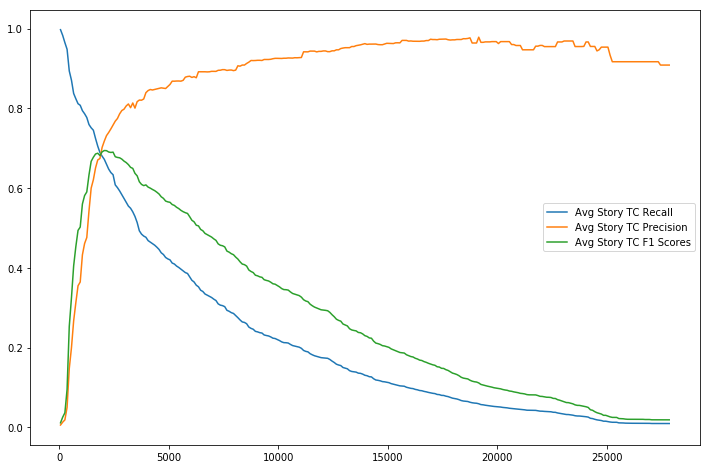

Max F1 Score: 0.6943


In [161]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

^ speed and efficacy gains from dropping the CountVectorizer use

In [170]:
%%time
class_titles_processed = class_docs_plus['title_processed'].copy()
n_titles = len(class_titles_processed)
embedding_dimensions = len(nlp(class_titles_processed[0]).vector)
class_titles_processed_embeddings = np.zeros((n_titles, embedding_dimensions))

for i in tqdm_notebook(np.arange(0, n_titles)):
    processed_title = class_titles_processed[i]
    if processed_title != '':
        token_embeddings = []
        token_weights = []
        for token in nlp(processed_title, disable=['ner']):
            token_embeddings += [token.vector]
            token_weights += [1.0]
        title_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
        class_titles_processed_embeddings[i] = title_embedding
        

CPU times: user 3min 57s, sys: 16 s, total: 4min 13s
Wall time: 3min 11s


In [171]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [172]:
%%time
ac_model.fit(class_titles_processed_embeddings)

CPU times: user 2min 47s, sys: 8.64 s, total: 2min 56s
Wall time: 2min 58s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

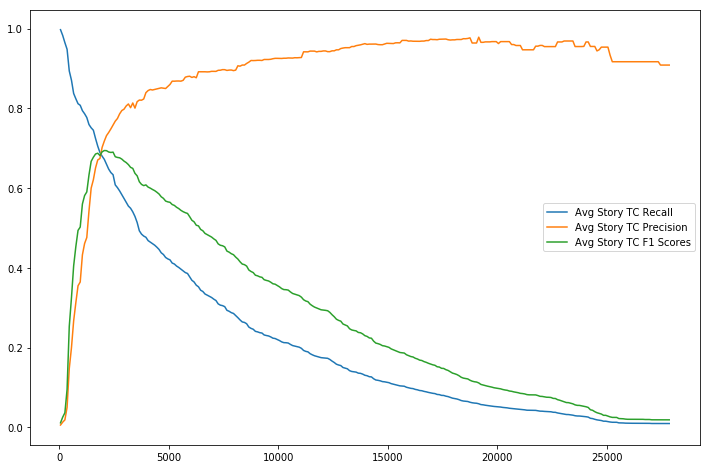

Max F1 Score: 0.6943


In [173]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

^ No gain from disabling just named entity recognition

In [174]:
%%time
class_titles_processed = class_docs_plus['title_processed'].copy()
n_titles = len(class_titles_processed)
embedding_dimensions = len(nlp(class_titles_processed[0]).vector)
class_titles_processed_embeddings = np.zeros((n_titles, embedding_dimensions))

for i in tqdm_notebook(np.arange(0, n_titles)):
    processed_title = class_titles_processed[i]
    if processed_title != '':
        token_embeddings = []
        token_weights = []
        for token in nlp(processed_title):
            token_embeddings += [token.vector]
            token_weights += [1.0]
        title_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
        class_titles_processed_embeddings[i] = title_embedding
        

CPU times: user 5min 10s, sys: 21.1 s, total: 5min 31s
Wall time: 4min 11s


In [175]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [176]:
%%time
ac_model.fit(class_titles_processed_embeddings)

CPU times: user 2min 42s, sys: 7.07 s, total: 2min 49s
Wall time: 2min 51s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

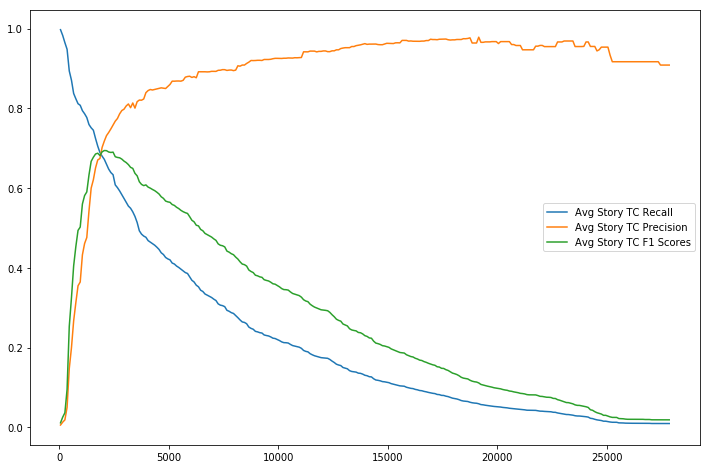

Max F1 Score: 0.6943


In [177]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

^ No gain from enabling all parts of spacy pipeline

## Clustering Algorithm Experimentation

***** Linkage: ward *****


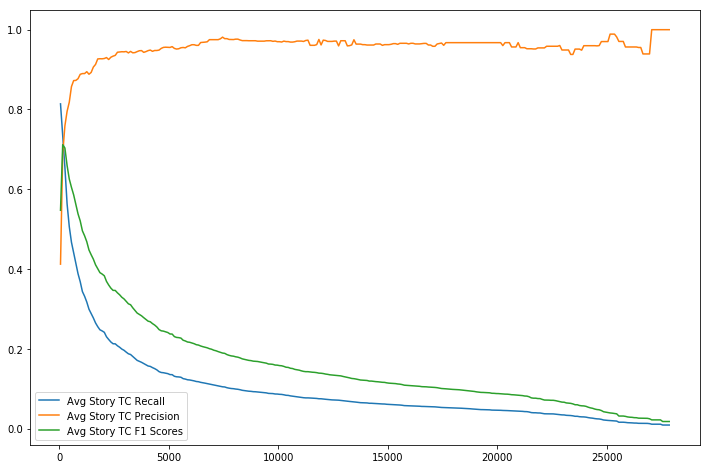

Max F1 Score: 0.7117
***** Linkage: complete *****


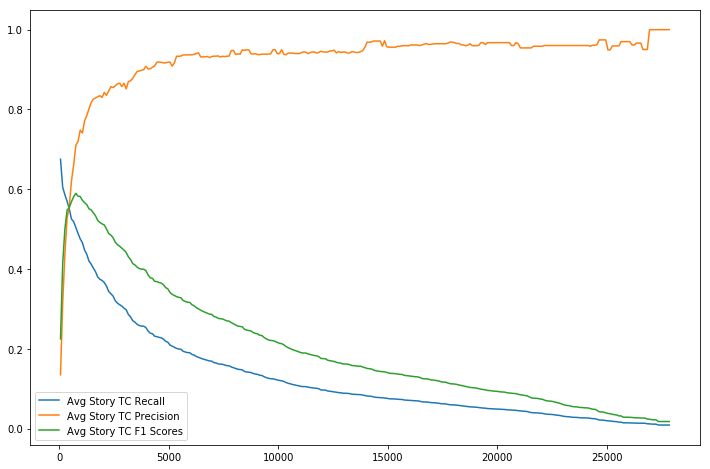

Max F1 Score: 0.5897
***** Linkage: average *****


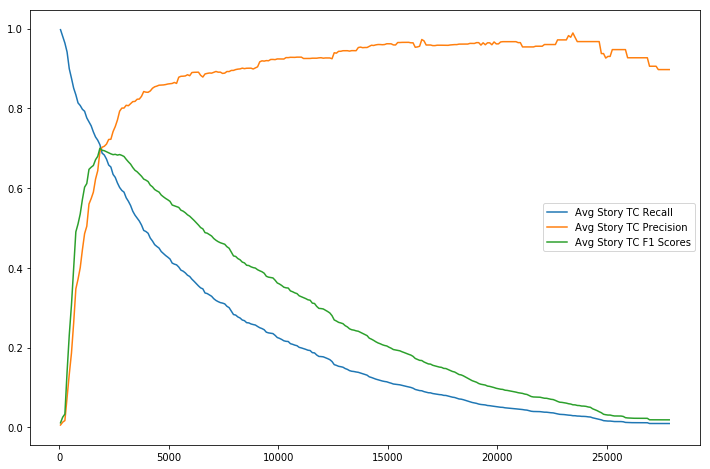

Max F1 Score: 0.7003
CPU times: user 28min 25s, sys: 1min 26s, total: 29min 52s
Wall time: 27min 2s


In [155]:
%%time
for linkage in ['ward', 'complete', 'average']:
    print('***** Linkage: %s *****' % linkage)
    class_titles_processed = class_docs_plus['title_processed'].copy()
    weights_vectorizer = CountVectorizer(
        ngram_range=(1, 1), min_df=0, max_df=1.0, binary=True,
        tokenizer=(lambda x: x.split()), preprocessor=(lambda x: x), 
        strip_accents=None, stop_words=None, lowercase=False
    )
    weights_matrix = weights_vectorizer.fit_transform(
        list(class_titles_processed)
    )
    weights_vocab = weights_vectorizer.get_feature_names()
    n_titles = len(class_titles_processed)
    embedding_dimensions = len(nlp(class_titles_processed[0]).vector)
    class_titles_processed_embeddings = np.zeros((n_titles, embedding_dimensions))

    for i in tqdm_notebook(np.arange(0, n_titles)):
        processed_title = class_titles_processed[i]
        if processed_title != '':
            token_embeddings = []
            token_weights = []
            for token in nlp(processed_title, disable=['ner']):
                if token.text in weights_vocab:
                    token_embeddings += [token.vector]
                    token_weights += [weights_matrix[i, weights_vocab.index(token.text)]
                                         * (1.30 if token.pos_ == 'PROPN' else 1.0)]
            if sum(token_weights) > 0:
                title_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
                class_titles_processed_embeddings[i] = title_embedding
                
    ac_model = AgglomerativeClustering(
        affinity='euclidean',
        linkage=linkage,
    )
    ac_model.fit(class_titles_processed_embeddings)
    plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

***** Affinity: l1 *****


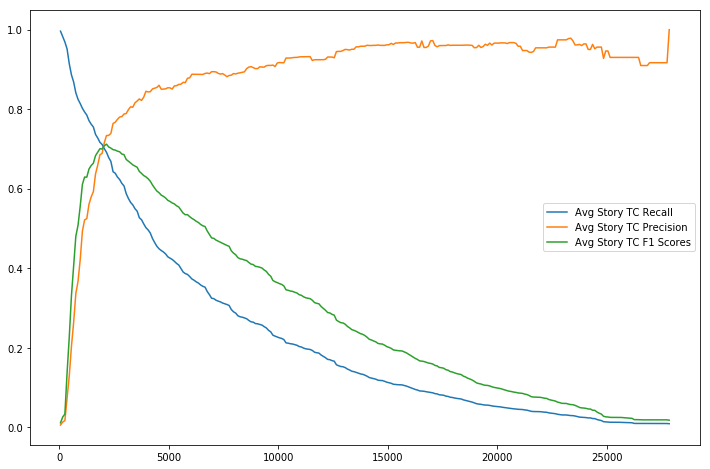

Max F1 Score: 0.7120
***** Affinity: l2 *****


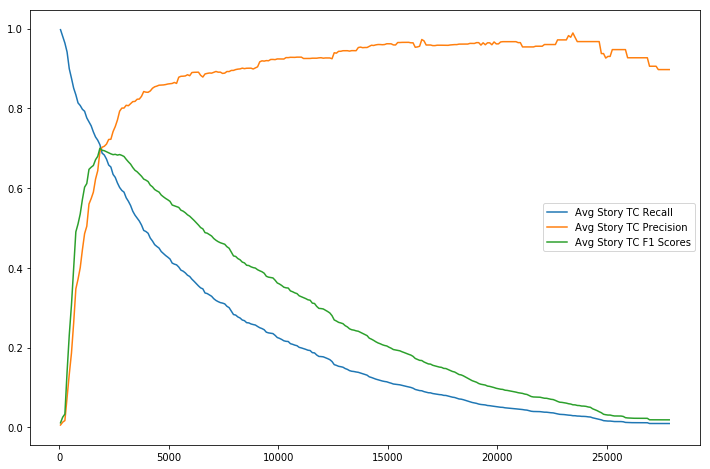

Max F1 Score: 0.7003
***** Affinity: manhattan *****


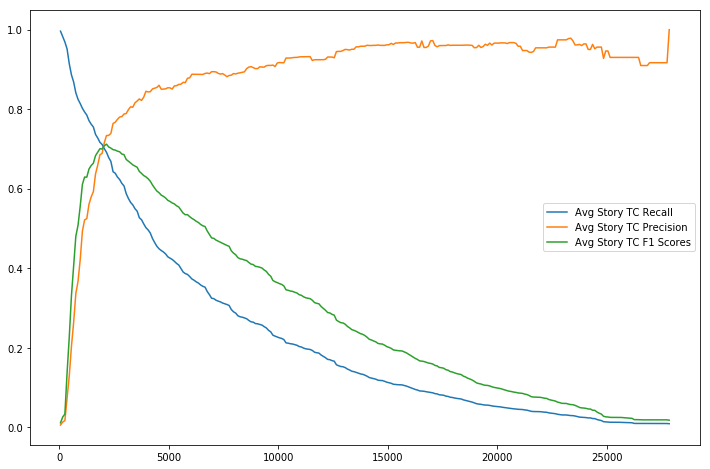

Max F1 Score: 0.7120
***** Affinity: cosine *****


ValueError: The condensed distance matrix must contain only finite values.

In [156]:
%%time
for affinity in ['l1', 'l2', 'manhattan', 'cosine']:
    print('***** Affinity: %s *****' % affinity)
    class_titles_processed = class_docs_plus['title_processed'].copy()
    weights_vectorizer = CountVectorizer(
        ngram_range=(1, 1), min_df=0, max_df=1.0, binary=True,
        tokenizer=(lambda x: x.split()), preprocessor=(lambda x: x), 
        strip_accents=None, stop_words=None, lowercase=False
    )
    weights_matrix = weights_vectorizer.fit_transform(
        list(class_titles_processed)
    )
    weights_vocab = weights_vectorizer.get_feature_names()
    n_titles = len(class_titles_processed)
    embedding_dimensions = len(nlp(class_titles_processed[0]).vector)
    class_titles_processed_embeddings = np.zeros((n_titles, embedding_dimensions))

    for i in tqdm_notebook(np.arange(0, n_titles)):
        processed_title = class_titles_processed[i]
        if processed_title != '':
            token_embeddings = []
            token_weights = []
            for token in nlp(processed_title, disable=['ner']):
                if token.text in weights_vocab:
                    token_embeddings += [token.vector]
                    token_weights += [weights_matrix[i, weights_vocab.index(token.text)]
                                         * (1.30 if token.pos_ == 'PROPN' else 1.0)]
            if sum(token_weights) > 0:
                title_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
                class_titles_processed_embeddings[i] = title_embedding
                
    ac_model = AgglomerativeClustering(
        affinity=affinity,
        linkage='average',
    )
    ac_model.fit(class_titles_processed_embeddings)
    plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

## Embedding Algorithm Experimentation

### TF-IDF vectors approach (agglomerative clustering)

In [43]:
class_tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1), stop_words='english', min_df=5, max_df=0.5
)

In [44]:
%%time
class_titles_processed_tfidf_matrix = class_tfidf_vectorizer.fit_transform(
    list(class_docs_plus['title_processed'])
)
class_titles_processed_tfidf_vocab = class_tfidf_vectorizer.get_feature_names()
print('Title vocab size: '+ str(len(class_titles_processed_tfidf_vocab)))

Title vocab size: 3389
CPU times: user 293 ms, sys: 10.3 ms, total: 303 ms
Wall time: 305 ms


In [45]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [46]:
%%time
ac_model.fit(class_titles_processed_tfidf_matrix.toarray())

CPU times: user 27min 13s, sys: 12.8 s, total: 27min 25s
Wall time: 27min 31s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

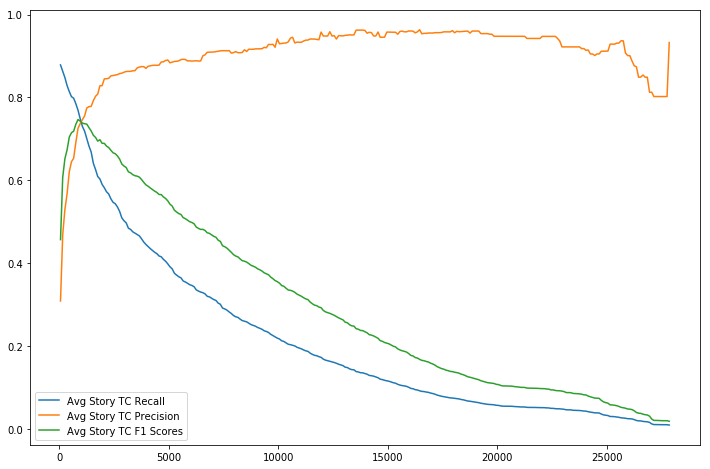

Max F1 Score: 0.7468


In [47]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

### LDA approach (agglomerative clustering)

In [48]:
from sklearn.decomposition import LatentDirichletAllocation

In [49]:
class_count_vectorizer = CountVectorizer(
    ngram_range=(1, 1), stop_words='english', min_df=0, max_df=1.0
)

In [50]:
%%time
class_titles_processed_count_matrix = class_count_vectorizer.fit_transform(
    list(class_docs_plus['title_processed'])
)
class_titles_processed_count_vocab = class_count_vectorizer.get_feature_names()
print('Title vocab size: '+ str(len(class_titles_processed_count_vocab)))

Title vocab size: 10047
CPU times: user 260 ms, sys: 12.9 ms, total: 273 ms
Wall time: 277 ms


In [51]:
lda_model = LatentDirichletAllocation(
    n_components=100,
    learning_method='online',
    n_jobs=2,
    batch_size=1000, # documents to analyze at a time; default: 2000
    evaluate_every=0, # log perplexity is estimated every this many updates; default: 0 = not evaluated
    learning_decay=0.7,
    learning_offset=10.0,
    max_iter=10, # number of passes through the data
    max_doc_update_iter=100,
    doc_topic_prior=None, # prior of document topic distribution theta (alpha); default: None = 1 / n_components
    topic_word_prior=None, # prior of topic word distribution beta (eta); default: None = 1 / n_components
    verbose=1
)

In [52]:
%%time
class_titles_processed_lda_embeddings = lda_model.fit_transform(class_titles_processed_count_matrix)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
CPU times: user 24.4 s, sys: 23.7 s, total: 48.1 s
Wall time: 1min 37s


In [53]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [54]:
%%time
ac_model.fit(class_titles_processed_lda_embeddings)

CPU times: user 1min 12s, sys: 7.5 s, total: 1min 20s
Wall time: 1min 21s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

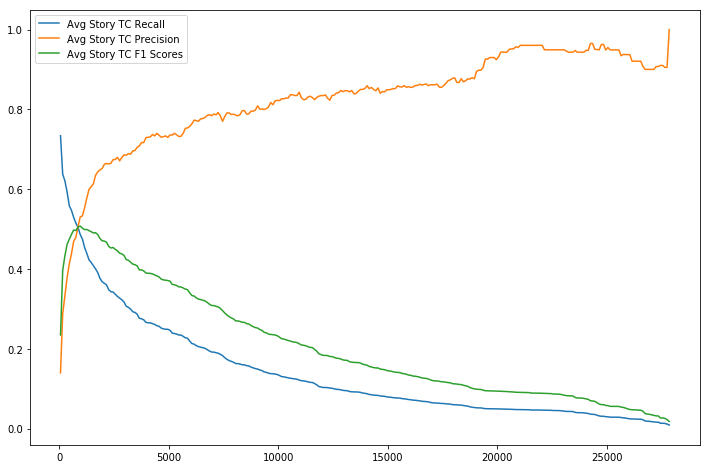

Max F1 Score: 0.5077


In [55]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

### Spacy doc embeddings approach (agglomerative clustering)

In [56]:
%%time
class_titles_processed_embeddings = reduce(lambda x, y: np.vstack((x, y)),
                                           [nlp(processed_title, disable=['parser', 'ner']).vector
                                            for processed_title in class_docs_plus['title_processed']]
)

CPU times: user 3min 29s, sys: 2min 39s, total: 6min 8s
Wall time: 6min


In [57]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [58]:
%%time
ac_model.fit(class_titles_processed_embeddings)

CPU times: user 2min 41s, sys: 6.49 s, total: 2min 48s
Wall time: 2min 49s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

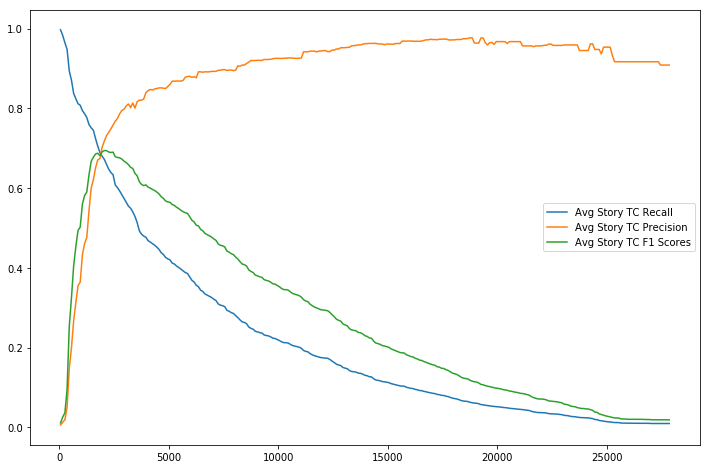

Max F1 Score: 0.6943


In [59]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

###  Spacy doc embeddings approach (agglomerative clustering) - verbs, adjectives, adverbs included

In [60]:
%%time
class_titles_processed = (
    class_docs_plus['title'].apply(lambda x: lemmatize(x, pos_to_keep=['PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV']))
)
class_titles_processed_embeddings = reduce(lambda x, y: np.vstack((x, y)),
                                           [nlp(processed_title, disable=['parser', 'ner']).vector
                                            for processed_title in class_titles_processed]
)

CPU times: user 4min 37s, sys: 2min 23s, total: 7min 1s
Wall time: 6min 37s


In [61]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [62]:
%%time
ac_model.fit(class_titles_processed_embeddings)

CPU times: user 2min 39s, sys: 6.23 s, total: 2min 46s
Wall time: 2min 47s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

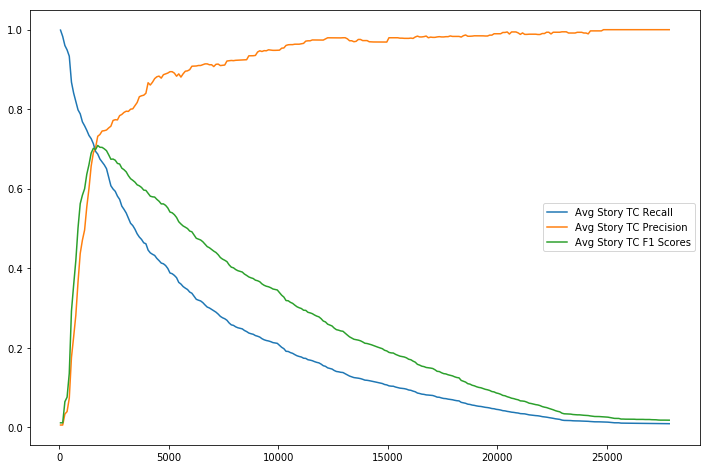

Max F1 Score: 0.7088


In [63]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

###  Spacy doc embeddings approach (agglomerative clustering) - verbs included

In [64]:
%%time
class_titles_processed = (
    class_docs_plus['title'].apply(lambda x: lemmatize(x, pos_to_keep=['PROPN', 'NOUN', 'VERB']))
)
class_titles_processed_embeddings = reduce(lambda x, y: np.vstack((x, y)),
                                           [nlp(processed_title, disable=['parser', 'ner']).vector
                                            for processed_title in class_titles_processed]
)

CPU times: user 4min 27s, sys: 2min 5s, total: 6min 32s
Wall time: 6min 7s


In [65]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [66]:
%%time
ac_model.fit(class_titles_processed_embeddings)

CPU times: user 2min 39s, sys: 6.7 s, total: 2min 46s
Wall time: 2min 47s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

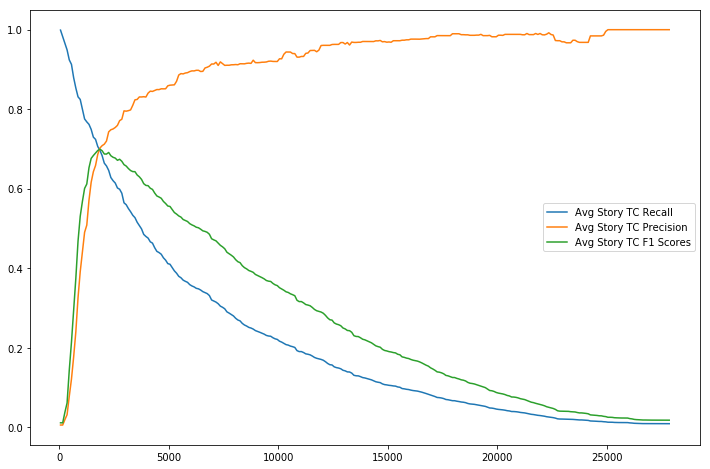

Max F1 Score: 0.6994


In [67]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

### TFIDF-weighted spacy word embeddings approach (agglomerative clustering)

In [105]:
%%time
class_titles_processed = class_docs_plus['title_processed'].copy()
weights_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1), min_df=0, max_df=1.0, binary=True,
    tokenizer=(lambda x: x.split()), preprocessor=(lambda x: x), 
    strip_accents=None, stop_words=None, lowercase=False
)
weights_matrix = weights_vectorizer.fit_transform(
    list(class_titles_processed)
)
weights_vocab = weights_vectorizer.get_feature_names()
n_titles = len(class_titles_processed)
embedding_dimensions = len(nlp(class_titles_processed[0]).vector)
class_titles_processed_embeddings = np.zeros((n_titles, embedding_dimensions))

for i in tqdm_notebook(np.arange(0, n_titles)):
    processed_title = class_titles_processed[i]
    if processed_title != '':
        token_embeddings = []
        token_weights = []
        for token in nlp(processed_title, disable=['parser', 'ner']):
            if token.text in weights_vocab:
                token_embeddings += [token.vector]
                token_weights += [weights_matrix[i, weights_vocab.index(token.text)]]
        if sum(token_weights) > 0:
            title_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
            class_titles_processed_embeddings[i] = title_embedding
        

CPU times: user 2min 45s, sys: 8.78 s, total: 2min 54s
Wall time: 2min 35s


In [106]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [107]:
%%time
ac_model.fit(class_titles_processed_embeddings)

CPU times: user 3min, sys: 11.5 s, total: 3min 11s
Wall time: 3min 16s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

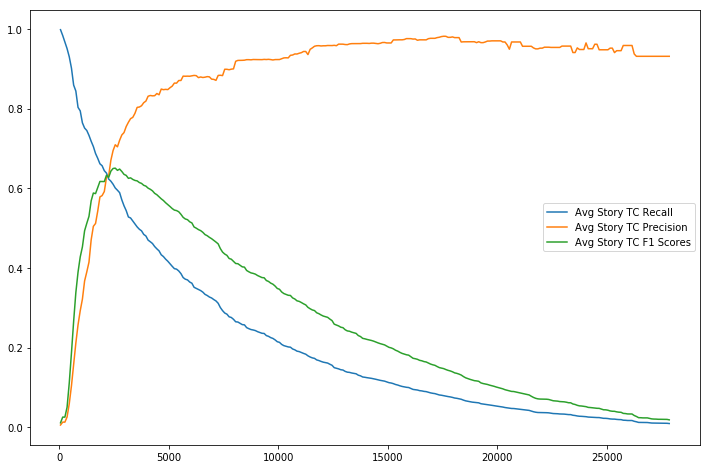

Max F1 Score: 0.6506


In [108]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

### Manually-averaged spacy word embeddings approach (agglomerative clustering)

In [109]:
%%time
class_titles_processed = class_docs_plus['title_processed'].copy()
weights_vectorizer = CountVectorizer(
    ngram_range=(1, 1), min_df=0, max_df=1.0, binary=True,
    tokenizer=(lambda x: x.split()), preprocessor=(lambda x: x), 
    strip_accents=None, stop_words=None, lowercase=False
)
weights_matrix = weights_vectorizer.fit_transform(
    list(class_titles_processed)
)
weights_vocab = weights_vectorizer.get_feature_names()
n_titles = len(class_titles_processed)
embedding_dimensions = len(nlp(class_titles_processed[0]).vector)
class_titles_processed_embeddings = np.zeros((n_titles, embedding_dimensions))

for i in tqdm_notebook(np.arange(0, n_titles)):
    processed_title = class_titles_processed[i]
    if processed_title != '':
        token_embeddings = []
        token_weights = []
        for token in nlp(processed_title, disable=['parser', 'ner']):
            if token.text in weights_vocab:
                token_embeddings += [token.vector]
                token_weights += [weights_matrix[i, weights_vocab.index(token.text)]]
        if sum(token_weights) > 0:
            title_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
            class_titles_processed_embeddings[i] = title_embedding
        

CPU times: user 2min 40s, sys: 8.8 s, total: 2min 49s
Wall time: 2min 30s


In [110]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [111]:
%%time
ac_model.fit(class_titles_processed_embeddings)

CPU times: user 2min 56s, sys: 10.3 s, total: 3min 6s
Wall time: 3min 11s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

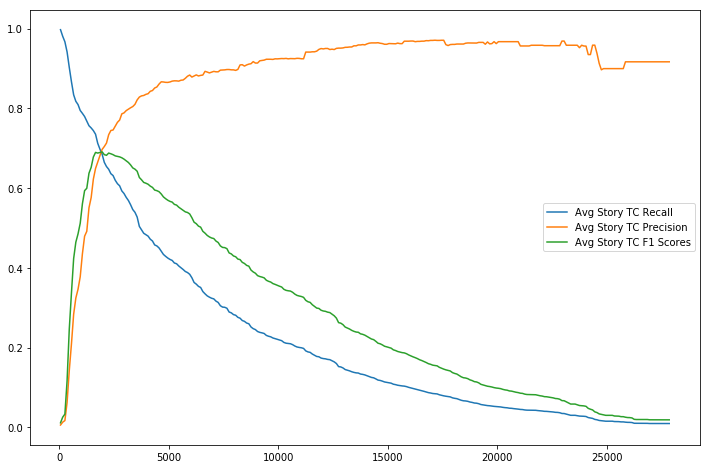

Max F1 Score: 0.6911


In [112]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

### Manually-averaged, propn-upweighted spacy word embeddings approach (agglomerative clustering)

***** Weight: 1.050 *****


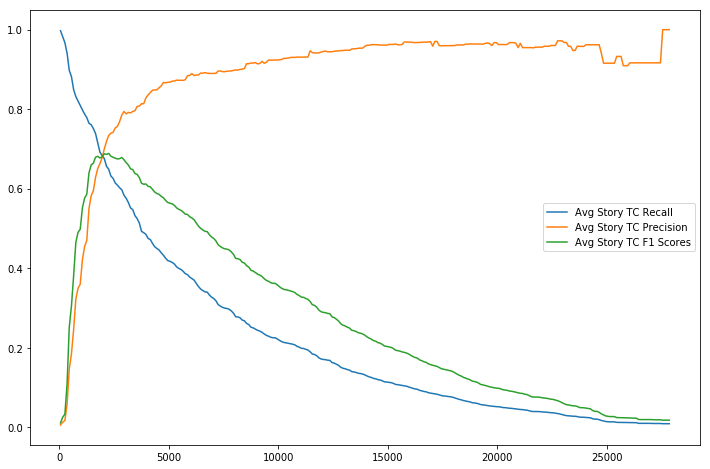

Max F1 Score: 0.6888
***** Weight: 1.100 *****


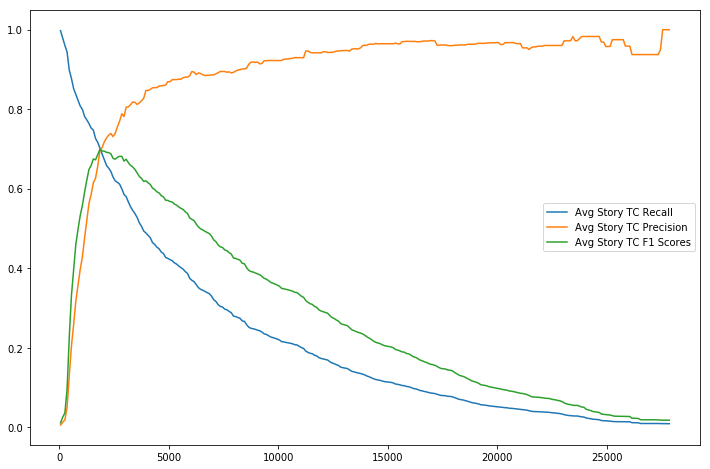

Max F1 Score: 0.6990
***** Weight: 1.150 *****


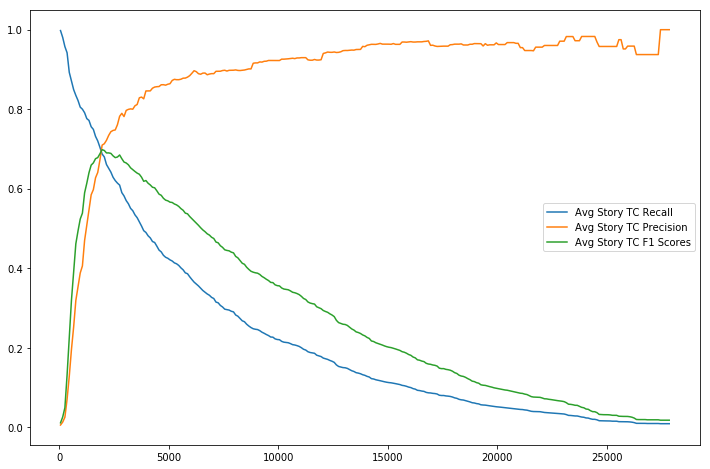

Max F1 Score: 0.6983
***** Weight: 1.200 *****


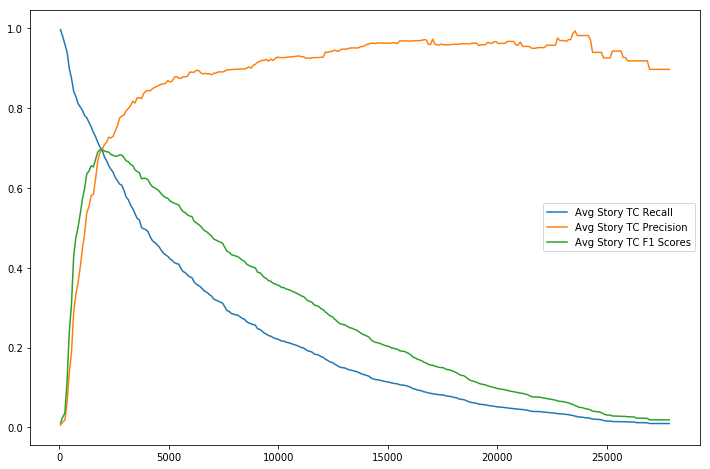

Max F1 Score: 0.6960
***** Weight: 1.250 *****


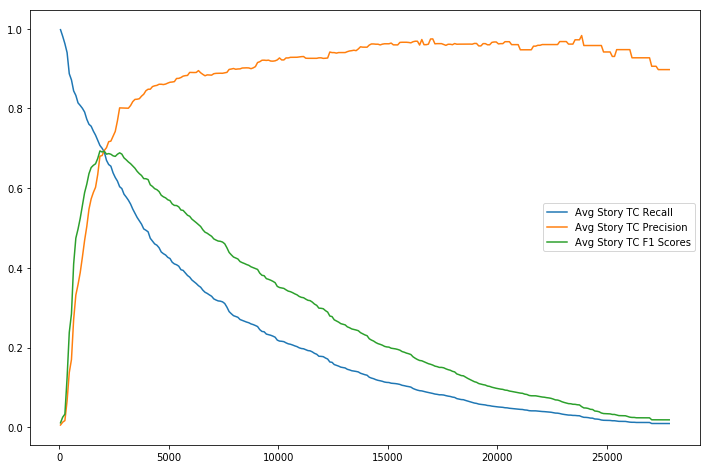

Max F1 Score: 0.6934
***** Weight: 1.300 *****


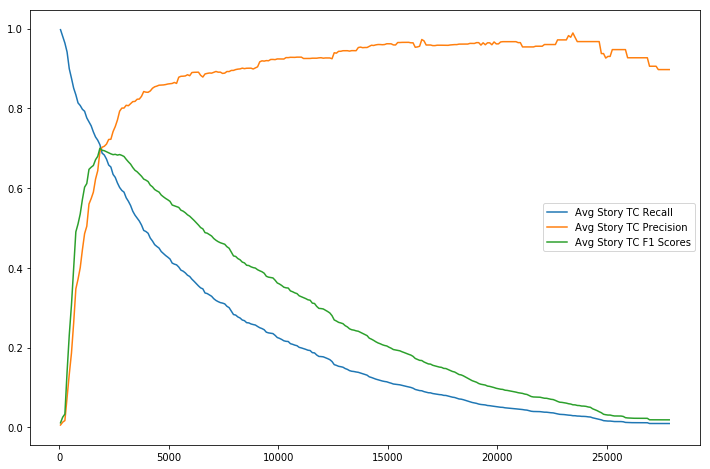

Max F1 Score: 0.7003
***** Weight: 1.350 *****


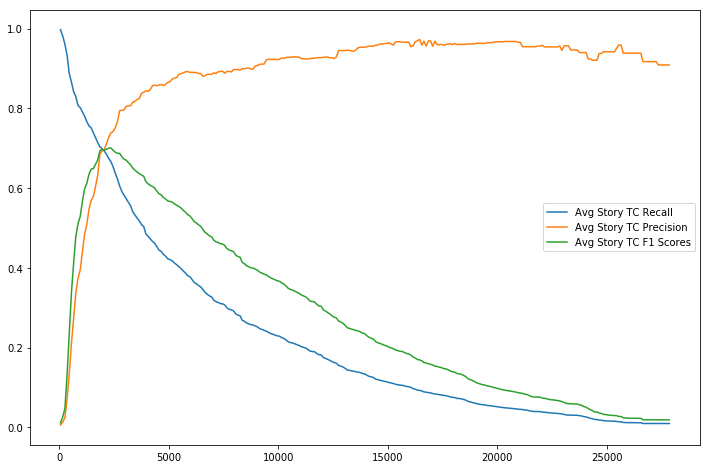

Max F1 Score: 0.7005
***** Weight: 1.400 *****


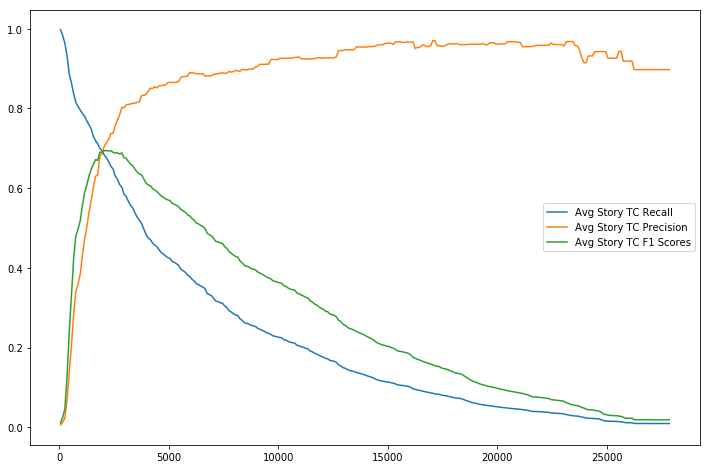

Max F1 Score: 0.6942
***** Weight: 1.450 *****


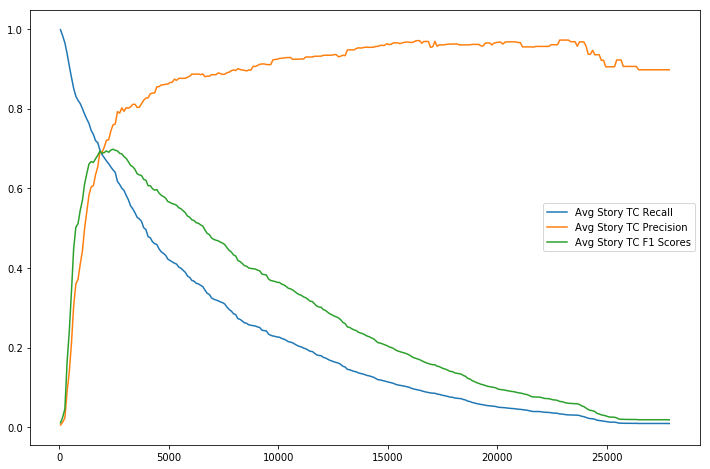

Max F1 Score: 0.6981
***** Weight: 1.500 *****


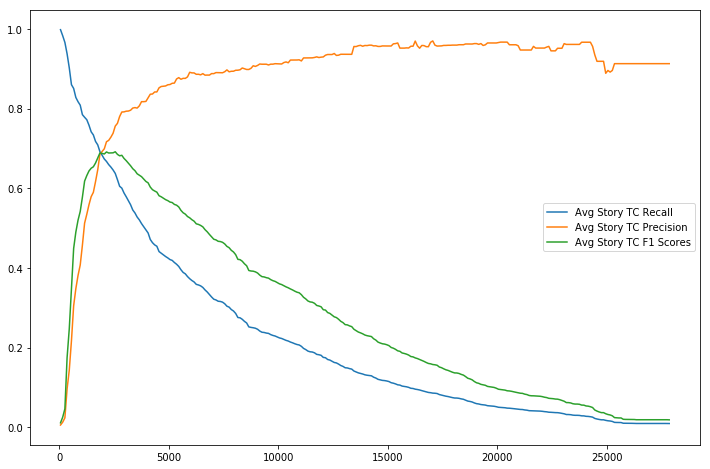

Max F1 Score: 0.6916
CPU times: user 1h 23min 5s, sys: 3min 42s, total: 1h 26min 48s
Wall time: 1h 18min 35s


In [118]:
%%time
for weight in [1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]:
    print('***** Weight: %0.3f *****' % weight)
    class_titles_processed = class_docs_plus['title_processed'].copy()
    weights_vectorizer = CountVectorizer(
        ngram_range=(1, 1), min_df=0, max_df=1.0, binary=True,
        tokenizer=(lambda x: x.split()), preprocessor=(lambda x: x), 
        strip_accents=None, stop_words=None, lowercase=False
    )
    weights_matrix = weights_vectorizer.fit_transform(
        list(class_titles_processed)
    )
    weights_vocab = weights_vectorizer.get_feature_names()
    n_titles = len(class_titles_processed)
    embedding_dimensions = len(nlp(class_titles_processed[0]).vector)
    class_titles_processed_embeddings = np.zeros((n_titles, embedding_dimensions))

    for i in tqdm_notebook(np.arange(0, n_titles)):
        processed_title = class_titles_processed[i]
        if processed_title != '':
            token_embeddings = []
            token_weights = []
            for token in nlp(processed_title, disable=['ner']):
                if token.text in weights_vocab:
                    token_embeddings += [token.vector]
                    token_weights += [weights_matrix[i, weights_vocab.index(token.text)]
                                         * (weight if token.pos_ == 'PROPN' else 1.0)]
            if sum(token_weights) > 0:
                title_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
                class_titles_processed_embeddings[i] = title_embedding
    
    ac_model = AgglomerativeClustering(
        affinity='euclidean',
        linkage='average',
    )
    ac_model.fit(class_titles_processed_embeddings)
    plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

### Manually-averaged, 1-pc-removed spacy word embeddings approach (agglomerative clustering)

In [122]:
from sklearn.decomposition import TruncatedSVD

In [123]:
#from https://github.com/PrincetonML/SIF/blob/master/src/SIF_embedding.py
def compute_pc(X,npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_


def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

In [124]:
%%time
class_titles_processed = class_docs_plus['title_processed'].copy()
weights_vectorizer = CountVectorizer(
    ngram_range=(1, 1), min_df=0, max_df=1.0, binary=True,
    tokenizer=(lambda x: x.split()), preprocessor=(lambda x: x), 
    strip_accents=None, stop_words=None, lowercase=False
)
weights_matrix = weights_vectorizer.fit_transform(
    list(class_titles_processed)
)
weights_vocab = weights_vectorizer.get_feature_names()
n_titles = len(class_titles_processed)
embedding_dimensions = len(nlp(class_titles_processed[0]).vector)
class_titles_processed_embeddings = np.zeros((n_titles, embedding_dimensions))

for i in tqdm_notebook(np.arange(0, n_titles)):
    processed_title = class_titles_processed[i]
    if processed_title != '':
        token_embeddings = []
        token_weights = []
        for token in nlp(processed_title, disable=['parser', 'ner']):
            if token.text in weights_vocab:
                token_embeddings += [token.vector]
                token_weights += [weights_matrix[i, weights_vocab.index(token.text)]]
        if sum(token_weights) > 0:
            title_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
            class_titles_processed_embeddings[i] = title_embedding
        

CPU times: user 2min 32s, sys: 8.13 s, total: 2min 40s
Wall time: 2min 22s


In [125]:
class_titles_processed_embeddings = remove_pc(class_titles_processed_embeddings)

In [126]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [127]:
%%time
ac_model.fit(class_titles_processed_embeddings)

CPU times: user 2min 47s, sys: 7.75 s, total: 2min 55s
Wall time: 2min 58s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

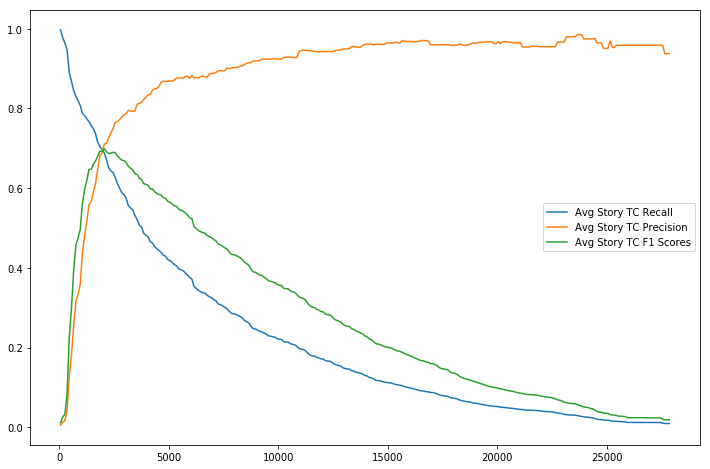

Max F1 Score: 0.6993


In [128]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

### Manually-averaged, 1-pc-removed, propn-upweighted spacy word embeddings approach (agglomerative clustering)

***** Weight: 1.050 *****


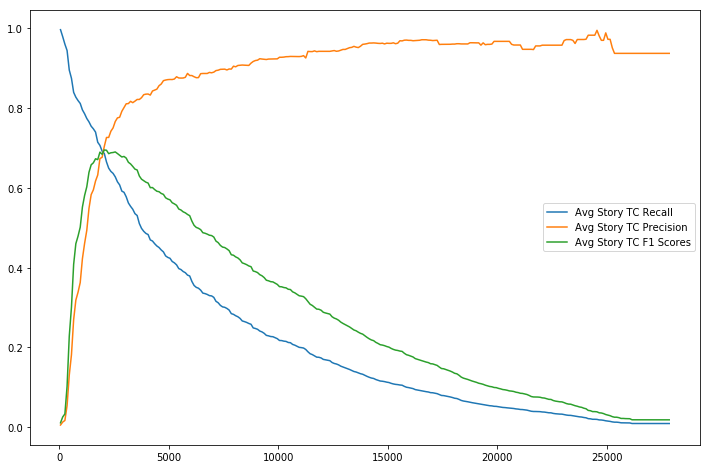

Max F1 Score: 0.6952
***** Weight: 1.100 *****


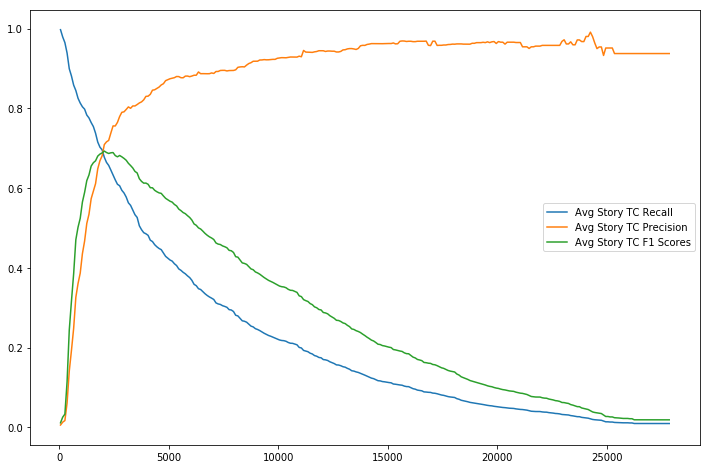

Max F1 Score: 0.6928
***** Weight: 1.150 *****


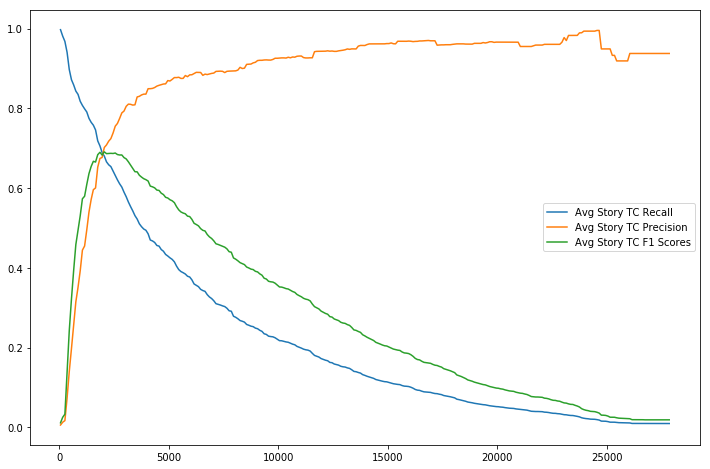

Max F1 Score: 0.6907
***** Weight: 1.200 *****


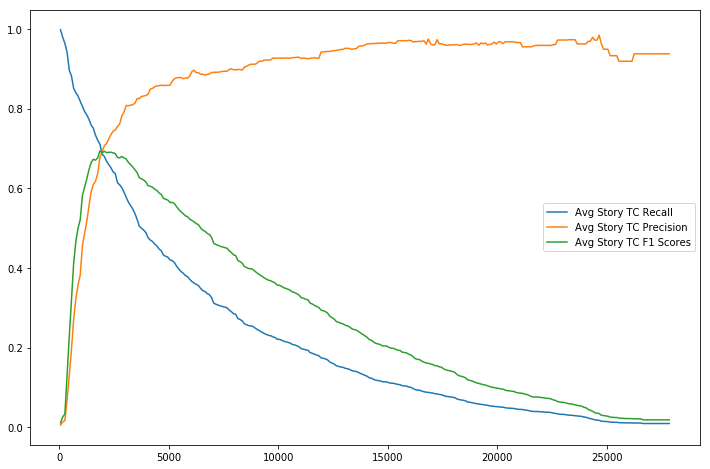

Max F1 Score: 0.6936
***** Weight: 1.250 *****


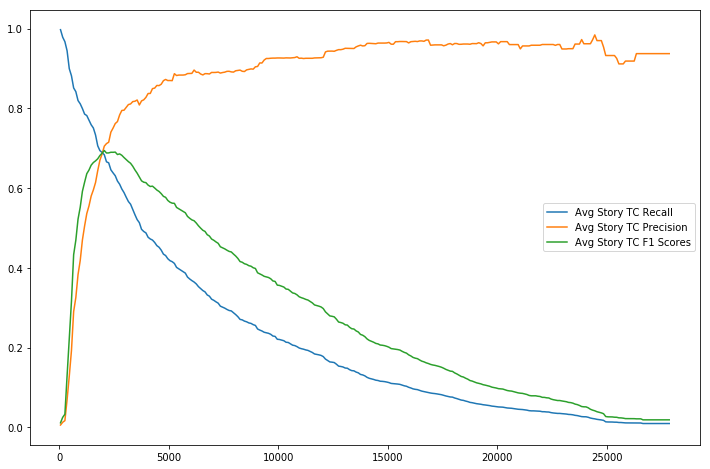

Max F1 Score: 0.6943
***** Weight: 1.300 *****


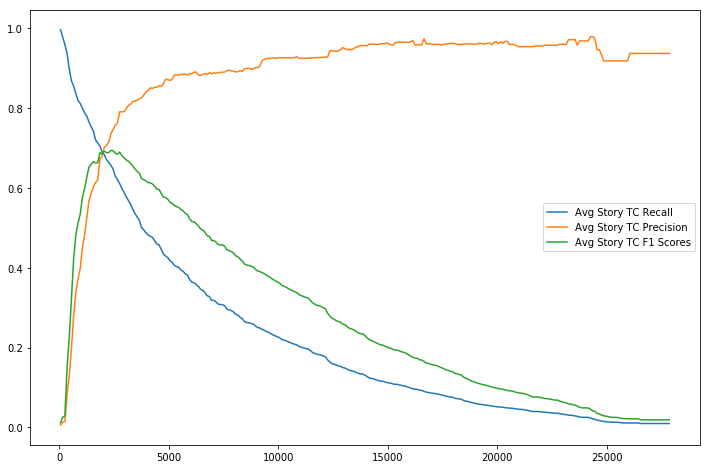

Max F1 Score: 0.6944
***** Weight: 1.350 *****


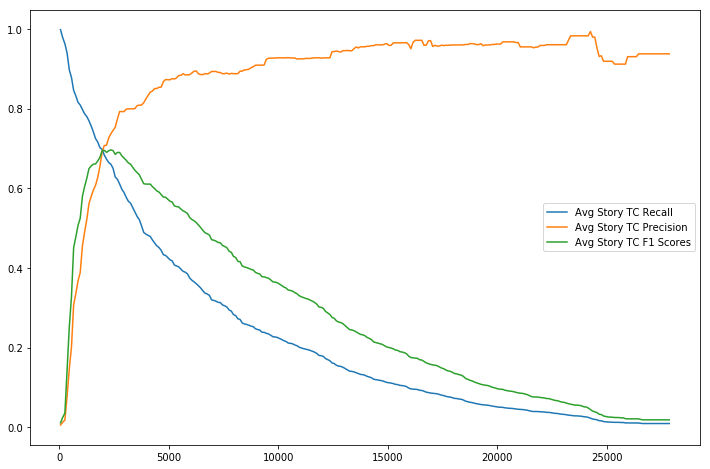

Max F1 Score: 0.6964
***** Weight: 1.400 *****


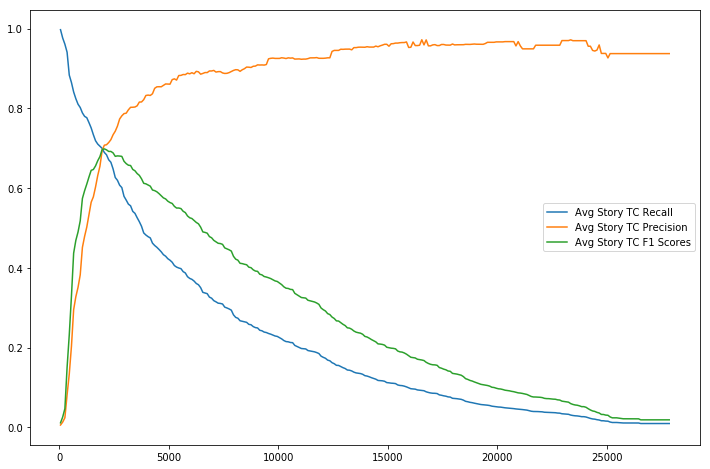

Max F1 Score: 0.6984
***** Weight: 1.450 *****


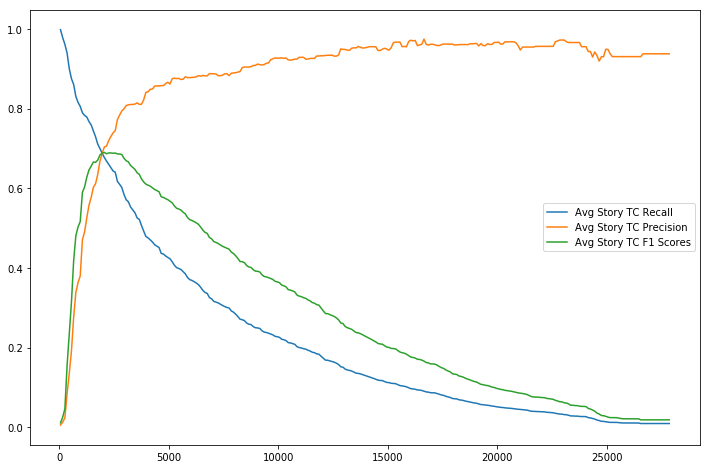

Max F1 Score: 0.6901
***** Weight: 1.500 *****


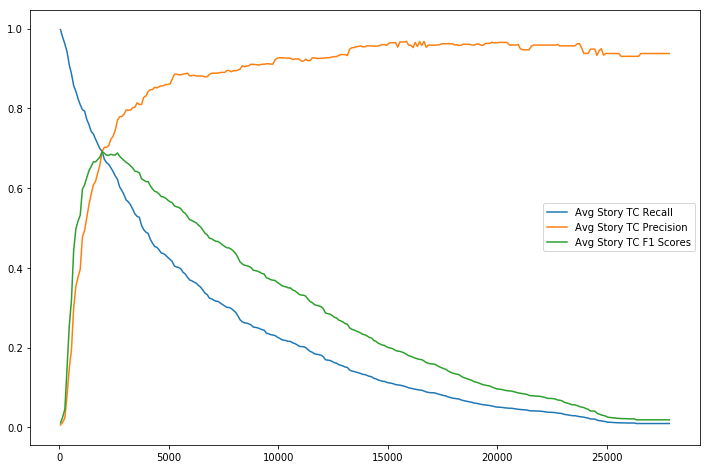

Max F1 Score: 0.6919
CPU times: user 1h 29min 45s, sys: 4min 28s, total: 1h 34min 14s
Wall time: 1h 25min 39s


In [130]:
%%time
for weight in [1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]:
    print('***** Weight: %0.3f *****' % weight)
    class_titles_processed = class_docs_plus['title_processed'].copy()
    weights_vectorizer = CountVectorizer(
        ngram_range=(1, 1), min_df=0, max_df=1.0, binary=True,
        tokenizer=(lambda x: x.split()), preprocessor=(lambda x: x), 
        strip_accents=None, stop_words=None, lowercase=False
    )
    weights_matrix = weights_vectorizer.fit_transform(
        list(class_titles_processed)
    )
    weights_vocab = weights_vectorizer.get_feature_names()
    n_titles = len(class_titles_processed)
    embedding_dimensions = len(nlp(class_titles_processed[0]).vector)
    class_titles_processed_embeddings = np.zeros((n_titles, embedding_dimensions))

    for i in tqdm_notebook(np.arange(0, n_titles)):
        processed_title = class_titles_processed[i]
        if processed_title != '':
            token_embeddings = []
            token_weights = []
            for token in nlp(processed_title, disable=['ner']):
                if token.text in weights_vocab:
                    token_embeddings += [token.vector]
                    token_weights += [weights_matrix[i, weights_vocab.index(token.text)]
                                         * (weight if token.pos_ == 'PROPN' else 1.0)]
            if sum(token_weights) > 0:
                title_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
                class_titles_processed_embeddings[i] = title_embedding
    
    class_titles_processed_embeddings = remove_pc(class_titles_processed_embeddings)
    
    ac_model = AgglomerativeClustering(
        affinity='euclidean',
        linkage='average',
    )
    ac_model.fit(class_titles_processed_embeddings)
    plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

### SIF-weighted spacy word embeddings approach (agglomerative clustering)

original work: https://openreview.net/pdf?id=SyK00v5xx

In [131]:
from sklearn.decomposition import TruncatedSVD

# from https://github.com/PrincetonML/SIF/blob/master/src/data_io.py
def getWordWeights(weightfile, a=1e-3):
    if a <=0: # when the parameter makes no sense, use unweighted
        a = 1.0

    word2weight = {}
    with open(weightfile) as f:
        lines = f.readlines()
    N = 0
    for i in lines:
        i=i.strip()
        if(len(i) > 0):
            i=i.split()
            if(len(i) == 2):
                word2weight[i[0]] = float(i[1])
                N += float(i[1])
            else:
                print(i)
    for key, value in word2weight.items():
        word2weight[key] = a / (a + value/N)
    return word2weight


#from https://github.com/PrincetonML/SIF/blob/master/src/SIF_embedding.py
def compute_pc(X,npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_


def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

In [132]:
word2weight = getWordWeights('/Users/robdearborn/Downloads/enwiki_vocab_min200.txt')
mean_weight = np.mean(list(word2weight.values()))

In [133]:
%%time
class_titles_processed = class_docs_plus['title_processed'].copy()
weights_vectorizer = CountVectorizer(
    ngram_range=(1, 1), min_df=0, max_df=1.0, binary=True,
    tokenizer=(lambda x: x.split()), preprocessor=(lambda x: x), 
    strip_accents=None, stop_words=None, lowercase=False
)
weights_matrix = weights_vectorizer.fit_transform(
    list(class_titles_processed)
)
weights_vocab = weights_vectorizer.get_feature_names()
n_titles = len(class_titles_processed)
embedding_dimensions = len(nlp(class_titles_processed[0]).vector)
class_titles_processed_embeddings = np.zeros((n_titles, embedding_dimensions))

for i in tqdm_notebook(np.arange(0, n_titles)):
    processed_title = class_titles_processed[i]
    if processed_title != '':
        token_embeddings = []
        token_weights = []
        for token in nlp(processed_title, disable=['parser', 'ner']):
            if token.text in weights_vocab:
                token_embeddings += [token.vector * (word2weight[token.text] 
                                                     if token.text in word2weight 
                                                     else mean_weight)]
                token_weights += [weights_matrix[i, weights_vocab.index(token.text)]]
        if sum(token_weights) > 0:
            title_embedding = np.average(token_embeddings, axis=0, weights=token_weights)
            class_titles_processed_embeddings[i] = title_embedding

CPU times: user 3min 6s, sys: 10.9 s, total: 3min 17s
Wall time: 2min 55s


In [134]:
class_titles_processed_embeddings = remove_pc(class_titles_processed_embeddings)

In [135]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [136]:
%%time
ac_model.fit(class_titles_processed_embeddings)

CPU times: user 3min 3s, sys: 11.3 s, total: 3min 14s
Wall time: 3min 20s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

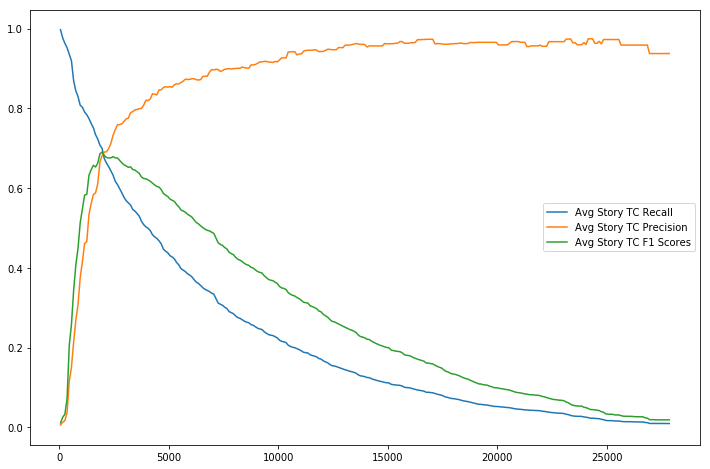

Max F1 Score: 0.6904


In [137]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

### Avg handmade word embeddings approach (agglomerative clustering)

In [138]:
from gensim.models import Word2Vec

In [139]:
%%time
class_docs['text_processed_for_word2vec'] = (
    class_docs['text'].apply(lambda x: lemmatize(x, 
                                                  pos_to_keep=['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV'], 
                                                  str_output=False))
)

CPU times: user 8min, sys: 45.1 s, total: 8min 45s
Wall time: 5min 15s


In [140]:
w2v_training_data = list(
    class_docs[class_docs['text_word_count'] > 200]['text_processed_for_word2vec']
)

In [141]:
%%time
W2V_DIMENSIONALITY = 100

w2v_model = Word2Vec(
    w2v_training_data,
    size=W2V_DIMENSIONALITY,
    iter=100
)

w2v_model_vocab = list(w2v_model.wv.vocab.keys())

CPU times: user 16min 38s, sys: 14.1 s, total: 16min 52s
Wall time: 5min 50s


In [142]:
len(w2v_model_vocab)

21440

original work: https://openreview.net/pdf?id=SyK00v5xx

In [143]:
# from https://github.com/PrincetonML/SIF/blob/master/src/data_io.py
def getWordWeights(weightfile, a=1e-3):
    if a <=0: # when the parameter makes no sense, use unweighted
        a = 1.0

    word2weight = {}
    with open(weightfile) as f:
        lines = f.readlines()
    N = 0
    for i in lines:
        i=i.strip()
        if(len(i) > 0):
            i=i.split()
            if(len(i) == 2):
                word2weight[i[0]] = float(i[1])
                N += float(i[1])
            else:
                print(i)
    for key, value in word2weight.items():
        word2weight[key] = a / (a + value/N)
    return word2weight

In [144]:
word2weight = getWordWeights('/Users/robdearborn/Downloads/enwiki_vocab_min200.txt')
mean_weight = np.mean(list(word2weight.values()))

In [145]:
class_onehot_vectorizer = CountVectorizer(
    ngram_range=(1, 1), stop_words='english', min_df=0, max_df=1.0, binary=True
)

In [146]:
%%time
class_titles_processed_onehot_matrix = class_onehot_vectorizer.fit_transform(
    list(class_docs_plus['title_processed'])
)
class_titles_processed_onehot_vocab = class_onehot_vectorizer.get_feature_names()
print('Title vocab size: '+ str(len(class_titles_processed_onehot_vocab)))

Title vocab size: 10047
CPU times: user 241 ms, sys: 7.06 ms, total: 248 ms
Wall time: 248 ms


In [147]:
%%time
class_titles_processed_onehot_vocab_weighted_embeddings = (
    reduce(lambda x, y: np.vstack((x, y)),
            [(w2v_model.wv[word] 
              if word in w2v_model_vocab
              else np.zeros(W2V_DIMENSIONALITY)
              * (word2weight[word] 
                 if word in word2weight 
                 else mean_weight))
             for word in class_titles_processed_onehot_vocab]
))

CPU times: user 14.7 s, sys: 9.9 s, total: 24.6 s
Wall time: 24.8 s


In [148]:
%%time
class_titles_processed_embeddings = (
    np.dot(class_titles_processed_onehot_matrix.toarray(),
           class_titles_processed_onehot_vocab_weighted_embeddings)
    / np.sum(class_titles_processed_onehot_matrix.toarray(), axis=1)[:, None]
)

CPU times: user 6.74 s, sys: 4.24 s, total: 11 s
Wall time: 6.93 s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [149]:
class_titles_processed_embeddings = (
    np.nan_to_num(class_titles_processed_embeddings)
)
# ^place wordless docs at origin

In [150]:
ac_model = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
)

In [151]:
%%time
ac_model.fit(class_titles_processed_embeddings)

CPU times: user 1min 26s, sys: 8.07 s, total: 1min 34s
Wall time: 1min 35s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x109cc7158>)

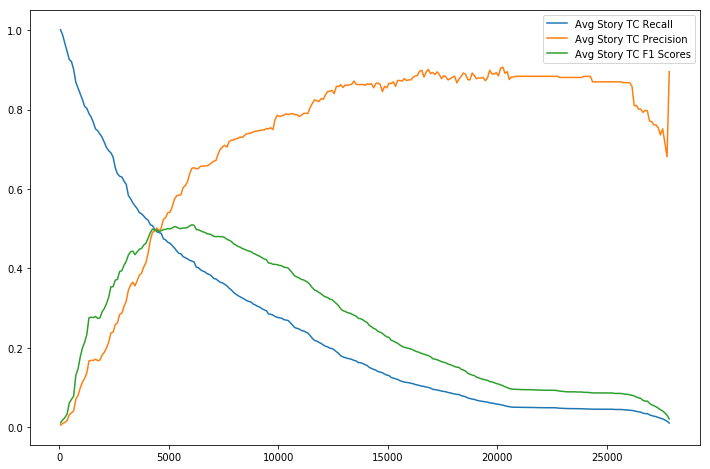

Max F1 Score: 0.5099


In [152]:
plot_ac_tradeoff(ac_model, class_docs_plus, story_ids_and_n_docs)

# Graveyard

In [ ]:
def plot_ac_tradeoff(ac_model, ac_matrix):
    ac_nodes = gen_ac_nodes(ac_model)
    n_docs = ac_model.n_leaves_

    cluster_matrices = dict(enumerate(
        list(ac_matrix)
    ))
    cluster_meta = {}
    n_clusters = []
    clusters_similarity = []

    for node in tqdm_notebook(ac_nodes):
        idx = node['idx']
        lc = node['left_child']
        rc = node['right_child']

        cluster_matrices[idx] = np.vstack((
            cluster_matrices[lc], 
            cluster_matrices[rc]
        ))
        del cluster_matrices[lc]
        del cluster_matrices[rc]

        cluster_count = 0
        cluster_similarities = []
        cluster_weights = []
        for cluster_id, cluster_matrix in cluster_matrices.items():
            cluster_count += 1
            if cluster_id in cluster_meta:
                cluster_similarity = cluster_meta[cluster_id]['cluster_similarity']
                cluster_weight = cluster_meta[cluster_id]['cluster_weight']
            else:
                if len(cluster_matrix.shape) == 1:
                    cluster_similarity = 1.0
                    cluster_weight = 1.0
                else: 
                    vector_similarities = cosine_similarity(cluster_matrix)
                    cluster_similarity = np.mean(vector_similarities)
                    cluster_weight = len(cluster_matrix)*1.0
                cluster_meta[cluster_id] = {
                    'cluster_similarity': cluster_similarity,
                    'cluster_weight': cluster_weight
                } 
            cluster_similarities += [cluster_similarity]
            cluster_weights += [cluster_weight]

        n_clusters += [cluster_count]
        clusters_similarity += [np.average(cluster_similarities,
                                           weights=cluster_weights)]
        
    print('Pseudo AUC: %0.4f' % np.mean(clusters_similarity))
    plt.plot(n_clusters, clusters_similarity)
    plt.show()
    plt.close()



### TF-IDF vectors approach (manual clustering)

In [ ]:
class_tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1), stop_words='english', min_df=5, max_df=0.5
)

In [ ]:
%%time
class_titles_processed_tfidf_matrix = class_tfidf_vectorizer.fit_transform(
    list(class_docs['title_processed'])
)
class_titles_processed_tfidf_vocab = class_tfidf_vectorizer.get_feature_names()
print('Title vocab size: '+ str(len(class_titles_processed_tfidf_vocab)))

In [ ]:
%%time
doc_similarities = cosine_similarity(class_titles_processed_tfidf_matrix)

In [ ]:
dist_sample = np.random.choice(doc_similarities[~np.eye(len(doc_similarities), dtype=bool)]
                               , 10000)
plt.hist(dist_sample, bins=100)
plt.title('Distribution of Doc Similarities')
plt.show()
p99_cluster_similarity = np.percentile(dist_sample, 99)
print('P99: %0.3f' % p99_cluster_similarity)

In [ ]:
MIN_CLUSTER_SIMILARITY = p99_cluster_similarity.copy()
doc_clusters = np.arange(0, n_class_docs)
similarities_to_beat = np.full(n_class_docs, MIN_CLUSTER_SIMILARITY)

In [ ]:
for i in tqdm_notebook(np.arange(0, n_class_docs)):
    for j in np.arange(i+1, n_class_docs):
        similarity_to_beat = similarities_to_beat[j]
        docs_similarity = doc_similarities[i, j]
        if docs_similarity > similarity_to_beat:
            doc_clusters[j] = i
            similarities_to_beat[j] = docs_similarity 

for i in tqdm_notebook(np.arange(0, n_class_docs)):
    if doc_clusters[i] != i:
        doc_clusters[i] = doc_clusters[doc_clusters[i]]
            

In [ ]:
class_docs['cluster'] = doc_clusters
cluster_counts = class_docs['cluster'].value_counts()
cluster_counts

In [ ]:
small_cluster_records = 0
for i in np.arange(1, 6):
    records = (sum(class_docs['cluster'].value_counts() == i)*i)
    print('Cluster Size %d: %d records' % (i, records))
    small_cluster_records += (sum(class_docs['cluster'].value_counts() == i)*i)
print('N Records in Small Clusters: '+ str(small_cluster_records))

In [ ]:
for item in class_docs[class_docs['cluster'] == 0]['title']:
    print(item)

In [ ]:
filt = ((class_docs['cluster'] != 0)
            & class_docs['title'].apply(lambda x: 'brennan' in x.lower()))
sum(filt)

In [ ]:
for item in class_docs[filt]['title']:
    print(item)

### Spacy doc embeddings approach (manual clustering)

In [ ]:
%%time
class_doc_vectors = reduce(lambda x, y: np.vstack((x, y)),
                           [nlp(doc, disable=['parser', 'ner']).vector
                            for doc in class_docs['title_processed']]
)

In [ ]:
%%time
doc_similarities = cosine_similarity(class_doc_vectors)

In [ ]:
dist_sample = np.random.choice(doc_similarities[~np.eye(len(doc_similarities), dtype=bool)]
                               , 10000)
plt.hist(dist_sample, bins=100)
plt.title('Distribution of Doc Similarities')
plt.show()
p99_cluster_similarity = np.percentile(dist_sample, 99)
print('P99: %0.3f' % p99_cluster_similarity)

In [ ]:
MIN_CLUSTER_SIMILARITY = p99_cluster_similarity.copy()
doc_clusters = np.arange(0, n_class_docs)
similarities_to_beat = np.full(n_class_docs, MIN_CLUSTER_SIMILARITY)

In [ ]:
for i in tqdm_notebook(np.arange(0, n_class_docs)):
    for j in np.arange(i+1, n_class_docs):
        similarity_to_beat = similarities_to_beat[j]
        docs_similarity = doc_similarities[i, j]
        if docs_similarity > similarity_to_beat:
            doc_clusters[j] = i
            similarities_to_beat[j] = docs_similarity 

for i in tqdm_notebook(np.arange(0, n_class_docs)):
    if doc_clusters[i] != i:
        doc_clusters[i] = doc_clusters[doc_clusters[i]]
            

In [ ]:
class_docs['cluster'] = doc_clusters
cluster_counts = class_docs['cluster'].value_counts()
cluster_counts

In [ ]:
small_cluster_records = 0
for i in np.arange(1, 6):
    records = (sum(class_docs['cluster'].value_counts() == i)*i)
    print('Cluster Size %d: %d records' % (i, records))
    small_cluster_records += (sum(class_docs['cluster'].value_counts() == i)*i)
print('N Records in Small Clusters: '+ str(small_cluster_records))

In [ ]:
for item in class_docs[class_docs['cluster'] == 1261]['title']:
    print(item)

In [ ]:
filt = ((class_docs['cluster'] != 1261)
            & class_docs['title'].apply(lambda x: 'brennan' in x.lower()))
sum(filt)

In [ ]:
for item in class_docs[filt]['title']:
    print(item)

### BOW --> Sklearn LDA approach (manual clustering)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [ ]:
count_vectorizer = CountVectorizer(
    ngram_range=(1, 1), stop_words='english', min_df=5, max_df=0.5
)

In [ ]:
%%time
class_titles_processed_count_matrix = count_vectorizer.fit_transform(
    list(class_docs['title_processed'])
)
class_titles_processed_count_vocab = count_vectorizer.get_feature_names()
print('Title vocab size: '+ str(len(class_titles_processed_count_vocab)))

In [ ]:
n_topics_to_try = [10, 25, 50, 100, 200]
learning_decays_to_try = [0.5, 0.7, 0.9]
learning_offsets_to_try = [1.0, 10.0]

In [ ]:
lda_search = (
    GridSearchCV(
        estimator=LatentDirichletAllocation(
            n_components=250,
            learning_method='online',
            n_jobs=2,
            batch_size=1000, # documents to analyze at a time; default: 2000
            evaluate_every=0, # log perplexity is estimated every this many updates; default: 0 = not evaluated
            max_iter=10, # number of passes through the data
            max_doc_update_iter=100,
            doc_topic_prior=None, # prior of document topic distribution theta (alpha); default: None = 1 / n_components
            topic_word_prior=None, # prior of topic word distribution beta (eta); default: None = 1 / n_components
            verbose=1
        ),
        param_grid={'n_topics': n_topics_to_try, 
                    'learning_decay': learning_decays_to_try,
                    'learning_offset': learning_offsets_to_try},
        verbose=1
    )
)

In [ ]:
%%time
lda_search.fit(class_titles_processed_count_matrix)

In [ ]:
# Get Log Likelyhoods from Grid Search Output
log_likelihoods_5_1 = [round(gscore.mean_validation_score) for gscore in lda_search.grid_scores_ 
                         if gscore.parameters['learning_decay']==0.5 and gscore.parameters['learning_offset']==1.0]
log_likelihoods_5_10 = [round(gscore.mean_validation_score) for gscore in lda_search.grid_scores_ 
                         if gscore.parameters['learning_decay']==0.5 and gscore.parameters['learning_offset']==10.0]
log_likelihoods_7_1 = [round(gscore.mean_validation_score) for gscore in lda_search.grid_scores_ 
                         if gscore.parameters['learning_decay']==0.7 and gscore.parameters['learning_offset']==1.0]
log_likelihoods_7_10 = [round(gscore.mean_validation_score) for gscore in lda_search.grid_scores_ 
                         if gscore.parameters['learning_decay']==0.7 and gscore.parameters['learning_offset']==10.0]
log_likelihoods_9_1 = [round(gscore.mean_validation_score) for gscore in lda_search.grid_scores_ 
                         if gscore.parameters['learning_decay']==0.9 and gscore.parameters['learning_offset']==1.0]
log_likelihoods_9_10 = [round(gscore.mean_validation_score) for gscore in lda_search.grid_scores_ 
                         if gscore.parameters['learning_decay']==0.9 and gscore.parameters['learning_offset']==10.0]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics_to_try, log_likelihoods_5_1, label='0.5 | 1.0')
plt.plot(n_topics_to_try, log_likelihoods_5_10, label='0.5 | 10.0')
plt.plot(n_topics_to_try, log_likelihoods_7_1, label='0.7 | 1.0')
plt.plot(n_topics_to_try, log_likelihoods_7_10, label='0.7 | 10.0')
plt.plot(n_topics_to_try, log_likelihoods_9_1, label='0.9 | 1.0')
plt.plot(n_topics_to_try, log_likelihoods_9_10, label='0.9 | 10.0')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [ ]:
# Best Model
lda = lda_search.best_estimator_

# Model Parameters
print("Best Model's Params: ", lda_search.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", lda_search.best_score_)

# Perplexity
print("Model Perplexity: ", lda.perplexity(class_titles_processed_count_matrix))


In [ ]:
%%time 
lda_Z = lda.fit_transform(class_titles_processed_count_matrix)

In [ ]:
def print_latent_topic_terms(latent_model, vocab, top_n=10):
    for idx, topic in enumerate(latent_model.components_[:10]):
        print("Topic %d:" % (idx))
        print([(vocab[i], topic[i]) 
               for i in topic.argsort()[:-top_n - 1:-1]])

In [ ]:
print_latent_topic_terms(lda, class_titles_processed_count_vocab)

In [ ]:
%%time
doc_similarities = cosine_similarity(lda_Z)

In [ ]:
dist_sample = np.random.choice(doc_similarities[~np.eye(len(doc_similarities), dtype=bool)]
                               , 10000)
plt.hist(dist_sample, bins=100)
plt.title('Distribution of Doc Similarities')
plt.show()
p99_cluster_similarity = np.percentile(dist_sample, 99)
print('P99: %0.3f' % p99_cluster_similarity)

In [ ]:
MIN_CLUSTER_SIMILARITY = p99_cluster_similarity.copy()
doc_clusters = np.arange(0, n_class_docs)
similarities_to_beat = np.full(n_class_docs, MIN_CLUSTER_SIMILARITY)

In [ ]:
for i in tqdm_notebook(np.arange(0, n_class_docs)):
    for j in np.arange(i+1, n_class_docs):
        similarity_to_beat = similarities_to_beat[j]
        docs_similarity = doc_similarities[i, j]
        if docs_similarity > similarity_to_beat:
            doc_clusters[j] = i
            similarities_to_beat[j] = docs_similarity 

for i in tqdm_notebook(np.arange(0, n_class_docs)):
    if doc_clusters[i] != i:
        doc_clusters[i] = doc_clusters[doc_clusters[i]]
            

In [ ]:
class_docs['cluster'] = doc_clusters
cluster_counts = class_docs['cluster'].value_counts()
cluster_counts

In [ ]:
small_cluster_records = 0
for i in np.arange(1, 6):
    records = (sum(class_docs['cluster'].value_counts() == i)*i)
    print('Cluster Size %d: %d records' % (i, records))
    small_cluster_records += (sum(class_docs['cluster'].value_counts() == i)*i)
print('N Records in Small Clusters: '+ str(small_cluster_records))

In [ ]:
for item in class_docs[class_docs['cluster'] == 15]['title']:
    print(item)

In [ ]:
filt = ((class_docs['cluster'] != 1521)
            & class_docs['title'].apply(lambda x: 'brennan' in x.lower()))
sum(filt)

In [ ]:
for item in class_docs[filt]['title']:
    print(item)